# **Bitcoin Time Series Momentum Trading**

In [1]:
from datetime import datetime, timedelta

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import polars as pl
import seaborn as sns
import talib as ta
import torch
import torch.nn as nn
import torch.optim as optim

from plotly.subplots import make_subplots
from scipy.stats import skew, kurtosis, mstats
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

In [2]:
bitcoin_1min = pl.read_csv("btcusd_1-min_data.csv")

bitcoin_1min = bitcoin_1min.with_columns(
    pl.from_epoch(pl.col("Timestamp"), time_unit="s").alias("Timestamp")
).rename({"Timestamp": "Date"})

print(bitcoin_1min)

shape: (6_729_281, 6)
┌─────────────────────┬──────────┬──────────┬──────────┬──────────┬───────────┐
│ Date                ┆ Open     ┆ High     ┆ Low      ┆ Close    ┆ Volume    │
│ ---                 ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---       │
│ datetime[μs]        ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64       │
╞═════════════════════╪══════════╪══════════╪══════════╪══════════╪═══════════╡
│ 2012-01-01 10:01:00 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 0.0       │
│ 2012-01-01 10:02:00 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 0.0       │
│ 2012-01-01 10:03:00 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 0.0       │
│ 2012-01-01 10:04:00 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 0.0       │
│ 2012-01-01 10:05:00 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 0.0       │
│ …                   ┆ …        ┆ …        ┆ …        ┆ …        ┆ …         │
│ 2024-12-15 23:57:00 ┆ 104510.0 ┆ 104510.0 ┆ 104257.0 ┆ 104268.0 ┆ 27.923539 │
│ 2024-12-15 23:58

In [3]:
print(bitcoin_1min.null_count())

shape: (1, 6)
┌──────┬──────┬──────┬─────┬───────┬────────┐
│ Date ┆ Open ┆ High ┆ Low ┆ Close ┆ Volume │
│ ---  ┆ ---  ┆ ---  ┆ --- ┆ ---   ┆ ---    │
│ u32  ┆ u32  ┆ u32  ┆ u32 ┆ u32   ┆ u32    │
╞══════╪══════╪══════╪═════╪═══════╪════════╡
│ 1    ┆ 0    ┆ 0    ┆ 0   ┆ 0     ┆ 0      │
└──────┴──────┴──────┴─────┴───────┴────────┘


In [4]:
bitcoin_1min = bitcoin_1min.filter(
    pl.col("Date").is_not_null()
)

## **Exploratory Data Analysis**

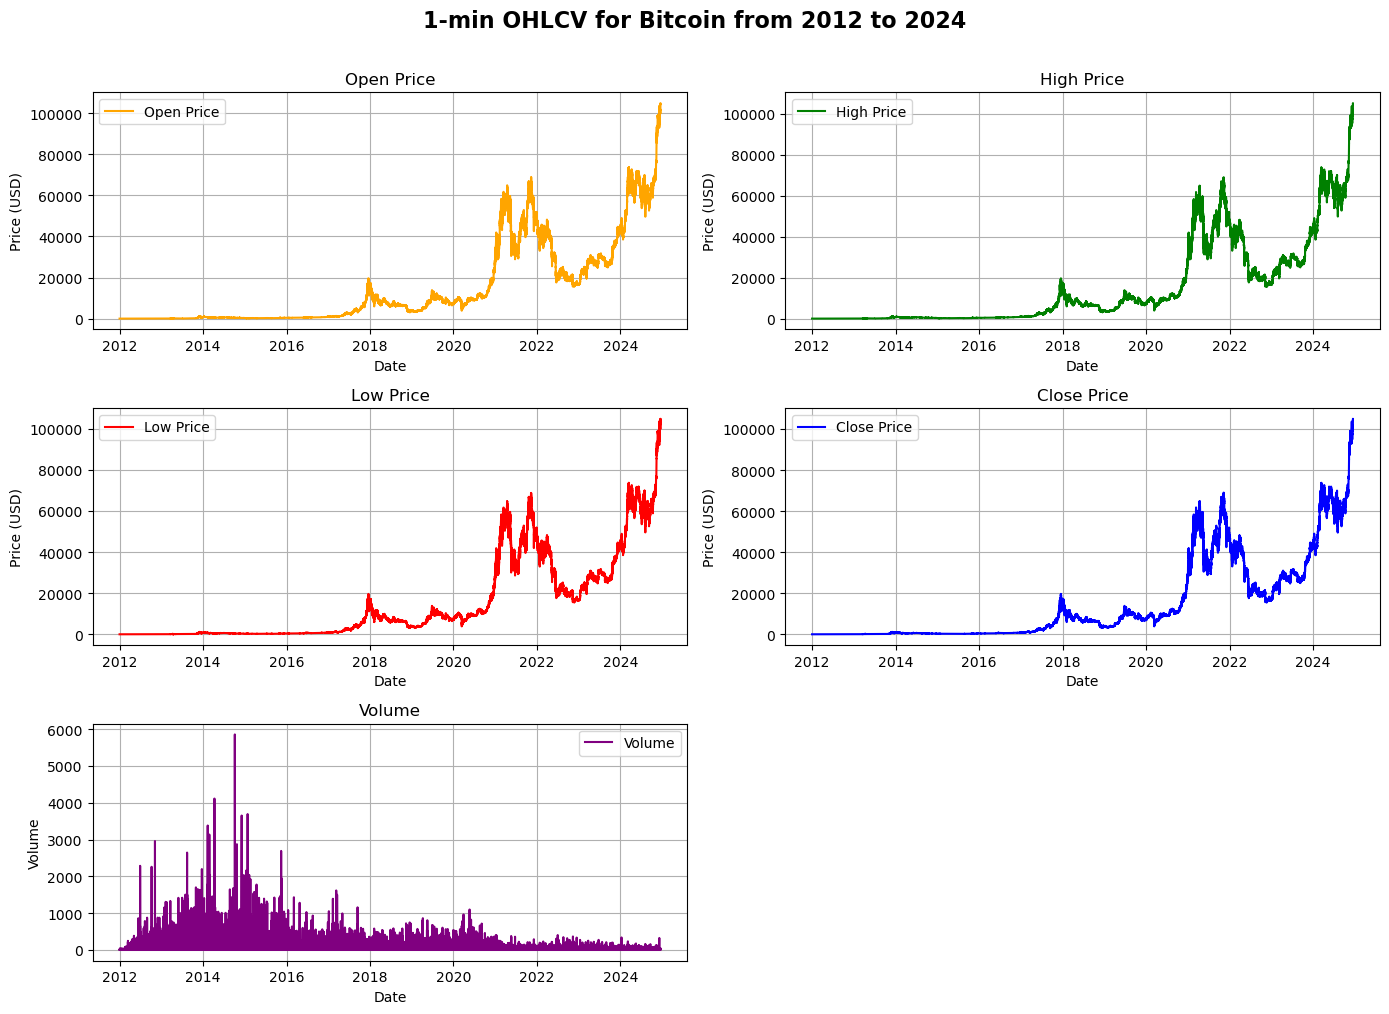

In [6]:
def plot_ohlcv(prices):
    """
    Plots Open, High, Low, Close and Volume prices in a 3x2 grid.

    Args:
        bitcoin (pl.DataFrame): Polars DataFrame containing OHLC and Volume data.
    """
    ohlcv_configs = [
        ("Open", "orange", "Open Price"),
        ("High", "green", "High Price"),
        ("Low", "red", "Low Price"),
        ("Close", "blue", "Close Price"),
        ("Volume", "purple", "Volume")
    ]

    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    plt.suptitle("1-min OHLCV for Bitcoin from 2012 to 2024", fontsize=16, fontweight="bold", y=1.01)
    axes = axes.flatten()

    for ax, (col_name, color, title) in zip(axes, ohlcv_configs):
        ax.plot(prices["Date"], prices[col_name], color=color, label=title)
        ax.set_title(title)
        ax.set_ylabel(f"Price (USD)" if col_name != "Volume" else "Volume")
        ax.set_xlabel("Date")
        ax.legend()
        ax.grid(True)

    for ax in axes[len(ohlcv_configs):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

plot_ohlcv(bitcoin_1min)

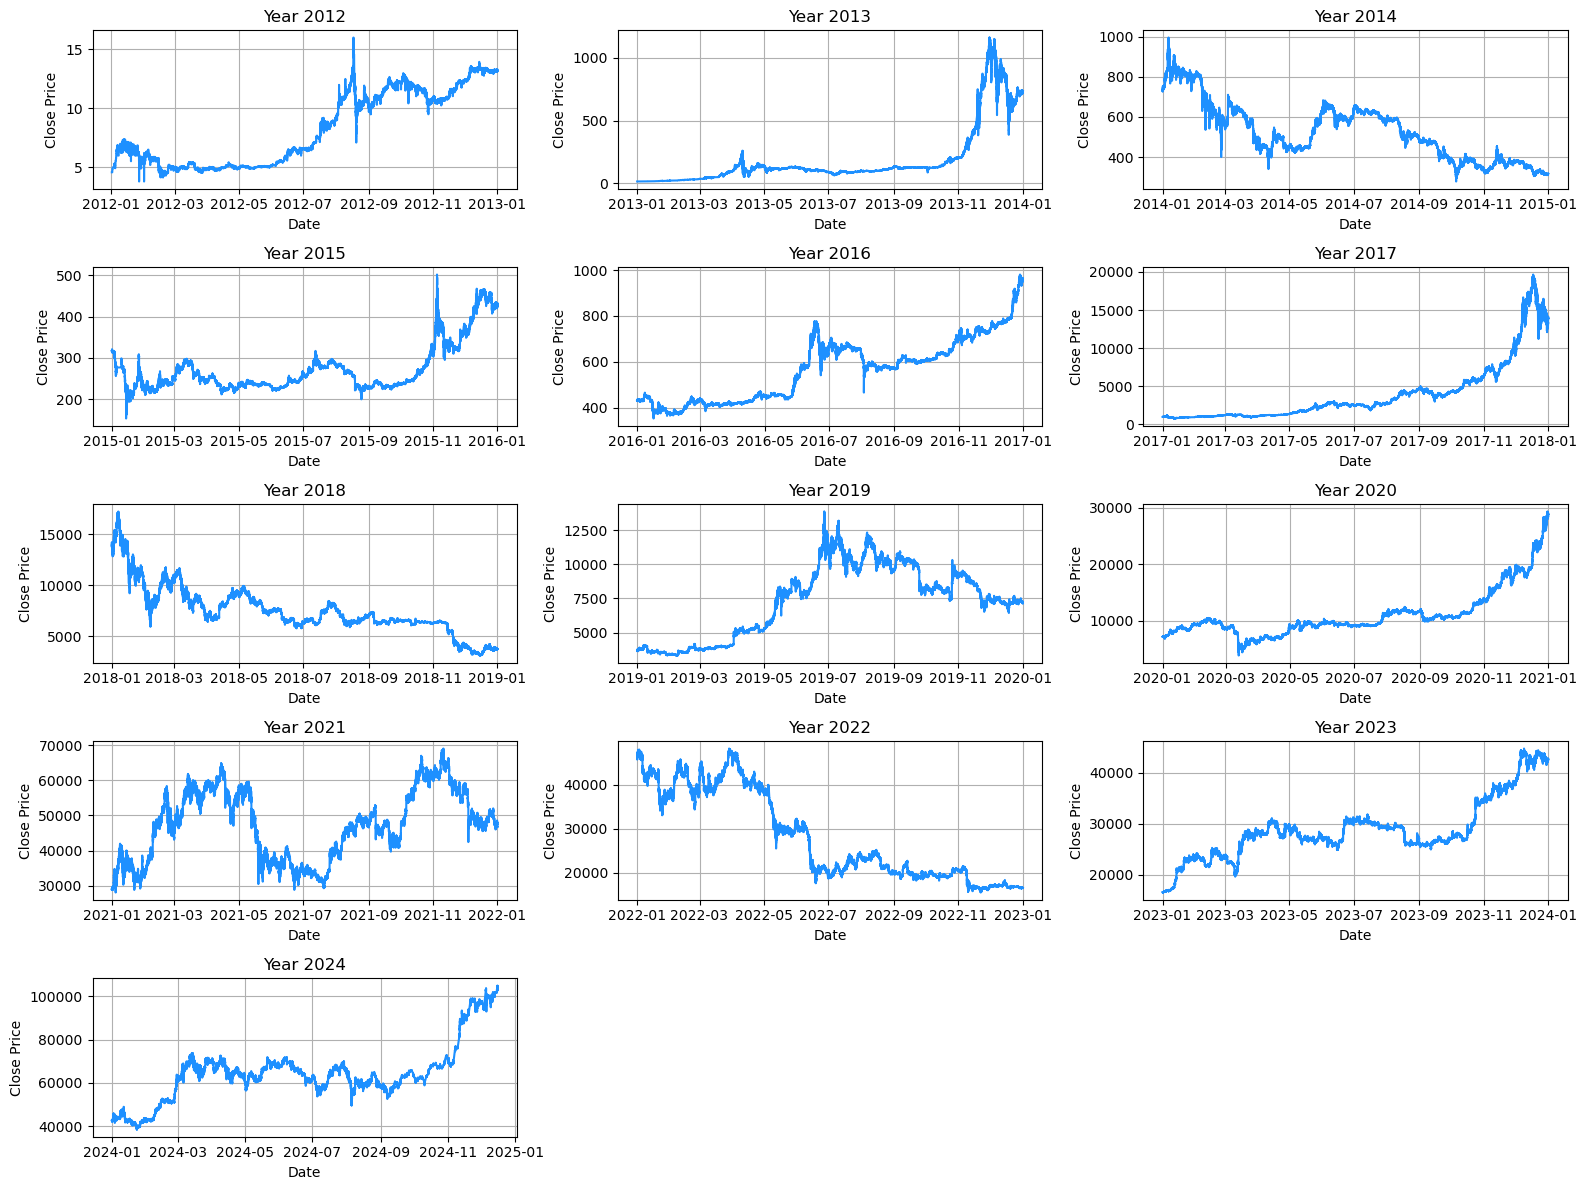

In [9]:
import polars as pl
import matplotlib.pyplot as plt

def plot_yearly_closing(prices):
    """
    Plots a grid of line plots showing Bitcoin closing prices for each year.

    Args:
        prices (pl.DataFrame): Polars DataFrame with 'Date' and 'Close' columns.
    """
    prices = prices.with_columns(pl.col("Date").dt.year().alias("year"))

    yearly_groups = prices.group_by("year").agg([
        pl.col("Date").alias("dates"),
        pl.col("Close").alias("close_prices")
    ]).sort("year")

    n_years = len(yearly_groups)
    n_cols = 3 
    n_rows = (n_years // n_cols) + (n_years % n_cols > 0)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))
    axes = axes.flatten()

    for i in range(n_years):
        ax = axes[i]

        year = yearly_groups["year"][i]
        dates = yearly_groups["dates"][i]
        close_prices = yearly_groups["close_prices"][i]

        ax.plot(dates, close_prices, color='dodgerblue')
        ax.set_title(f"Year {year}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Close Price")
        ax.grid(True)

    plt.tight_layout()
    plt.show()

plot_yearly_closing(bitcoin_1min)

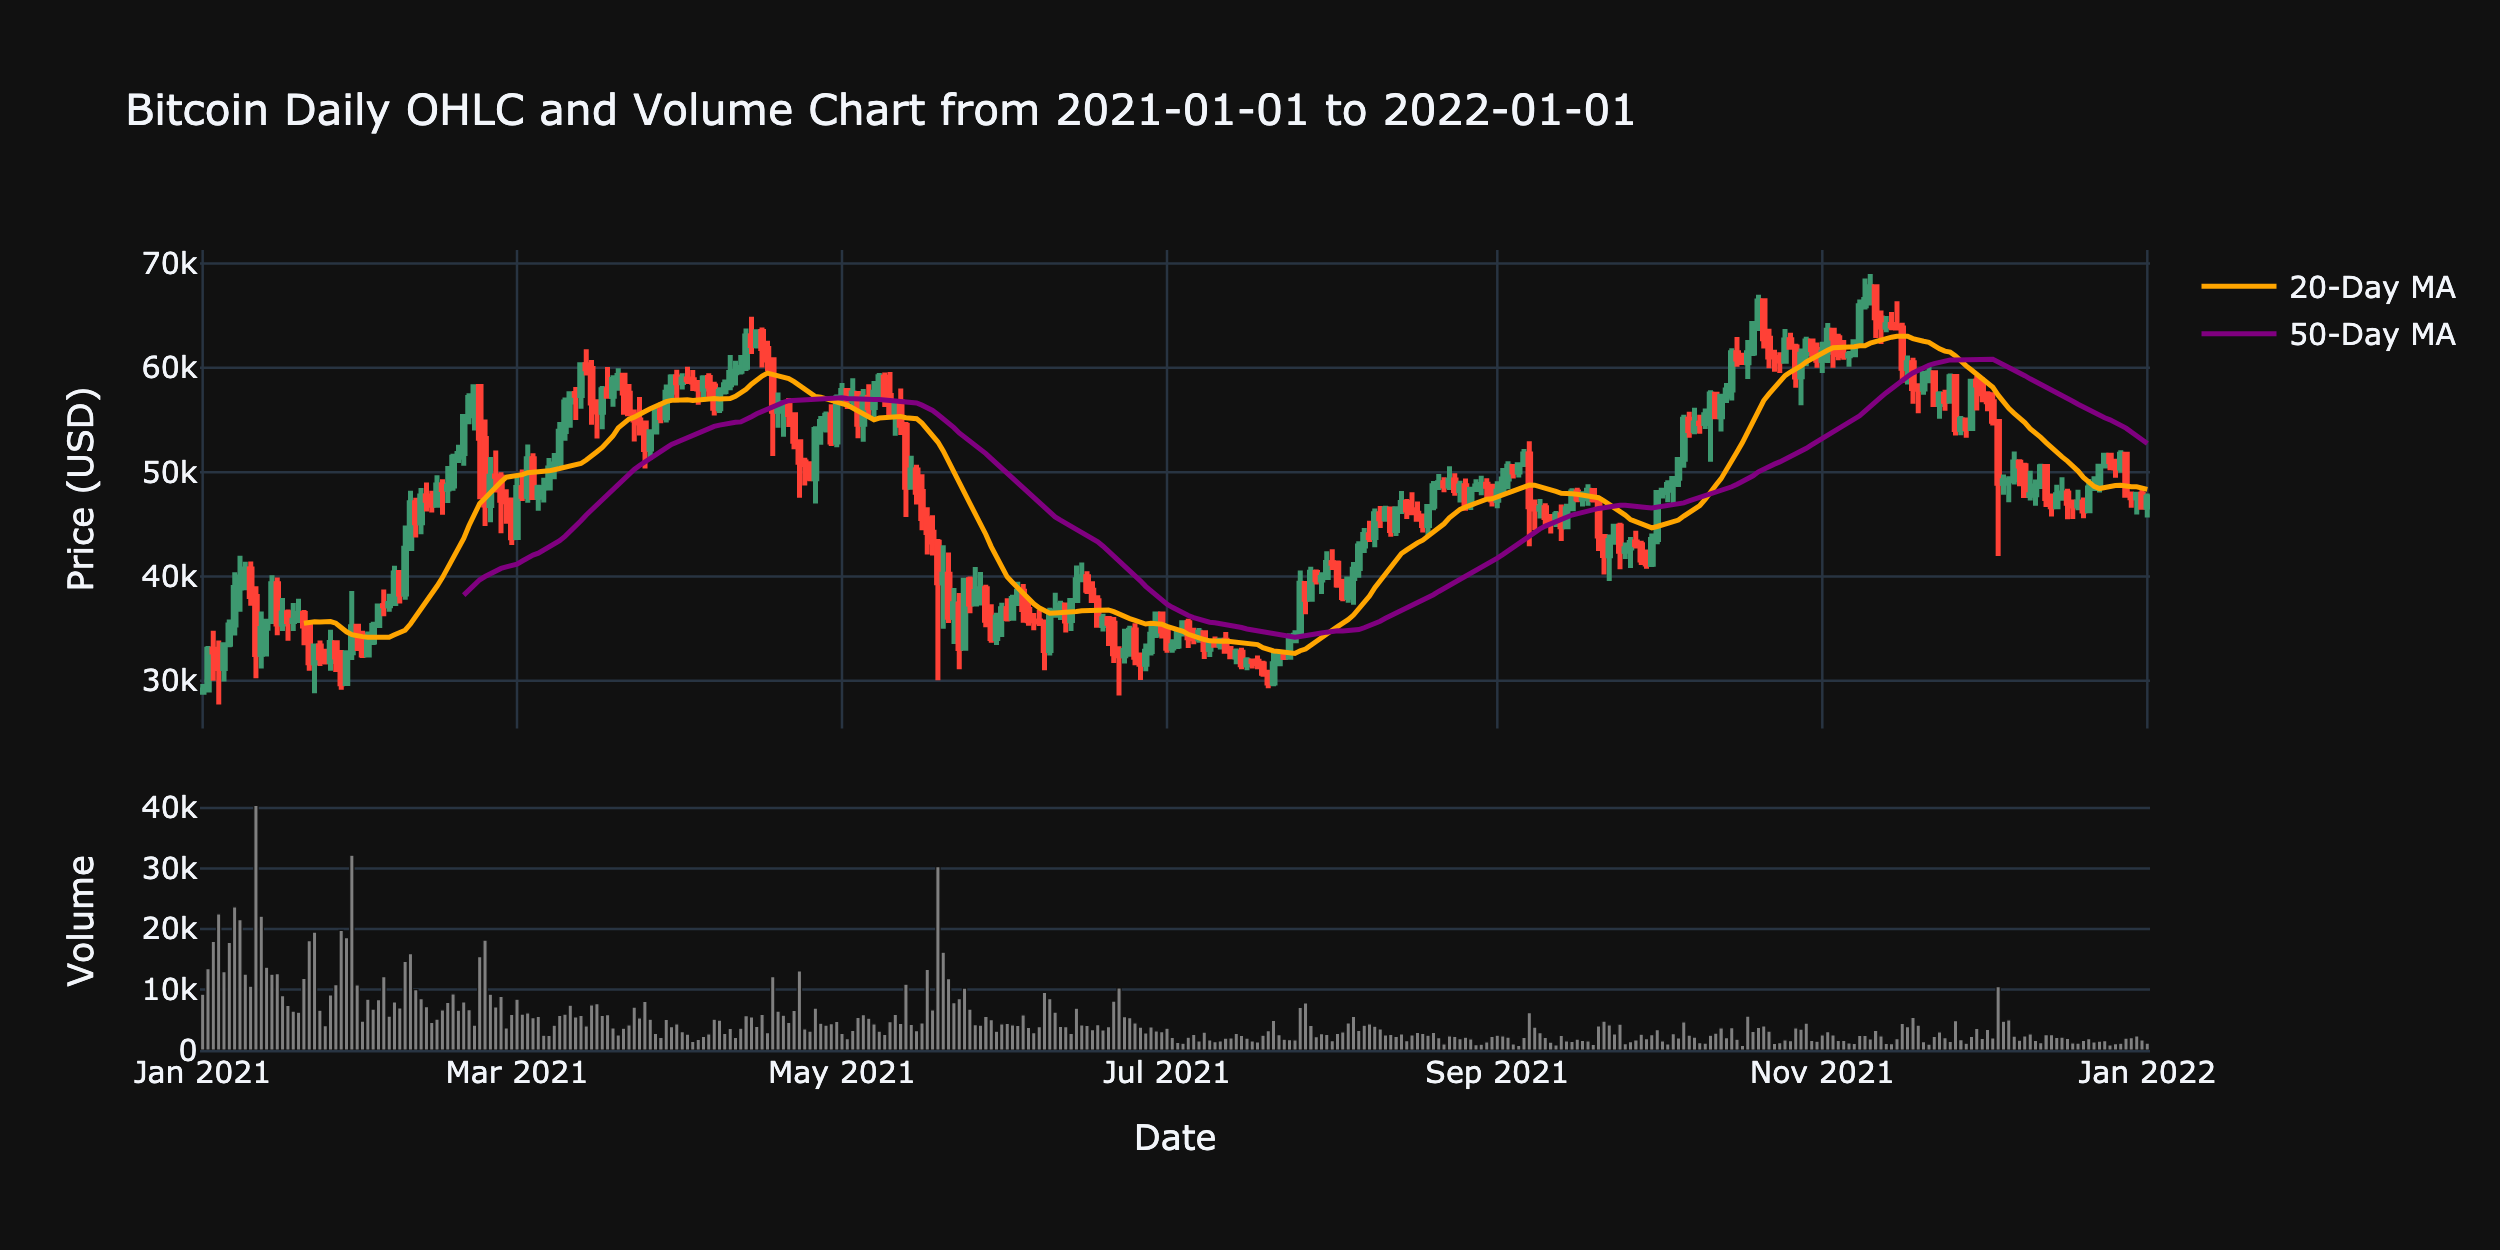

In [21]:
from IPython.display import Image
def plot_daily_candlesticks(prices, start, end=None):
    prices_daily = prices.group_by(
        pl.col("Date").dt.date().alias("Day")
    ).agg([
        pl.col("Open").first().alias("Open"),
        pl.col("High").max().alias("High"),
        pl.col("Low").min().alias("Low"),
        pl.col("Close").last().alias("Close"),
        pl.col("Volume").sum().alias("Volume")
    ]).sort("Day")

    if end:
        prices_daily = prices_daily.filter(
            pl.col("Day") >= start,
            pl.col("Day") <= end
        )
    else:
        prices_daily = prices_daily.filter(
            pl.col("Day") >= start
        )

    prices_daily = prices_daily.with_columns(
        pl.col("Close").rolling_mean(window_size=20).alias("MA_20"),
        pl.col("Close").rolling_mean(window_size=50).alias("MA_50")
    )

    fig = make_subplots(
        rows=2, cols=1, shared_xaxes=True, 
        row_heights=[0.65, 0.35],  
        vertical_spacing=0.08, 
    )

    fig.add_trace(
        go.Candlestick(
            x=prices_daily.select('Day').to_series(),
            open=prices_daily.select('Open').to_series(),
            high=prices_daily.select('High').to_series(),
            low=prices_daily.select('Low').to_series(),
            close=prices_daily.select('Close').to_series(),
            showlegend=False
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=prices_daily.select('Day').to_series(),
            y=prices_daily.select('MA_20').to_series(),
            line=dict(color='orange', width=2),
            name="20-Day MA"
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=prices_daily.select('Day').to_series(),
            y=prices_daily.select('MA_50').to_series(),
            line=dict(color='purple', width=2),
            name="50-Day MA"
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Bar(
            x=prices_daily.select('Day').to_series(),
            y=prices_daily.select('Volume').to_series(),
            marker_color="gray",
            showlegend=False
        ),
        row=2, col=1
    )

    min_date = prices_daily["Day"].min()
    max_date = prices_daily["Day"].max()
    fig.update_layout(
        title_text=f"Bitcoin Daily OHLC and Volume Chart from {min_date} to {max_date}",
        yaxis_title="Price (USD)",
        xaxis2_title="Date",
        yaxis2_title="Volume",
        template="plotly_dark",
        width=1000, height=600,
        xaxis_rangeslider_visible=False,
        showlegend=True,
    )
    fig.write_image("plots/candlesticks.png", scale=2.5, width=1000, height=500)

plot_daily_candlesticks(bitcoin_1min, datetime(2021, 1,1), datetime(2022, 1, 1))
Image("plots/candlesticks.png")

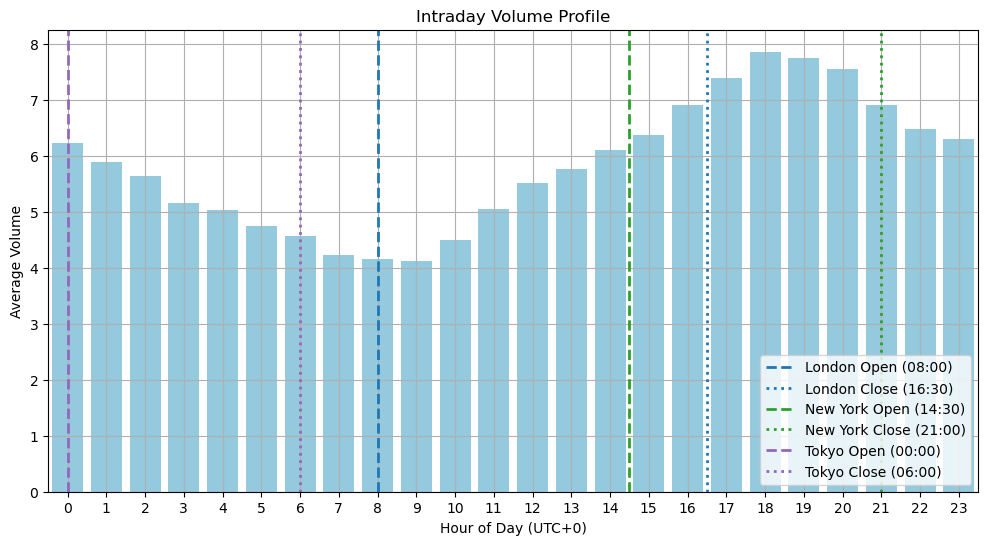

In [22]:
def plot_intraday_volume_profile(prices):
    prices = prices.with_columns(
        prices.select("Date").to_series().dt.hour().alias("hour")
    )

    avg_volume_by_hour = (prices.group_by("hour")
        .agg(pl.col("Volume").mean().alias("Average_Volume"))
        .sort("hour")
    )

    plt.figure(figsize=(12, 6))
    sns.barplot(x=avg_volume_by_hour["hour"], y=avg_volume_by_hour["Average_Volume"], color="skyblue")

    plt.title("Intraday Volume Profile")
    plt.xlabel("Hour of Day (UTC+0)")

    plt.axvline(x=8, color='#1f77b4', linestyle='--', linewidth=2, label="London Open (08:00)")
    plt.axvline(x=16.5, color='#1f77b4', linestyle=':', linewidth=2, label="London Close (16:30)")

    plt.axvline(x=14.5, color='#2ca02c', linestyle='--', linewidth=2, label="New York Open (14:30)")
    plt.axvline(x=21, color='#2ca02c', linestyle=':', linewidth=2, label="New York Close (21:00)")

    plt.axvline(x=0, color='#9467bd', linestyle='--', linewidth=2, label="Tokyo Open (00:00)")
    plt.axvline(x=6, color='#9467bd', linestyle=':', linewidth=2, label="Tokyo Close (06:00)")

    plt.ylabel("Average Volume")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

plot_intraday_volume_profile(bitcoin_1min)

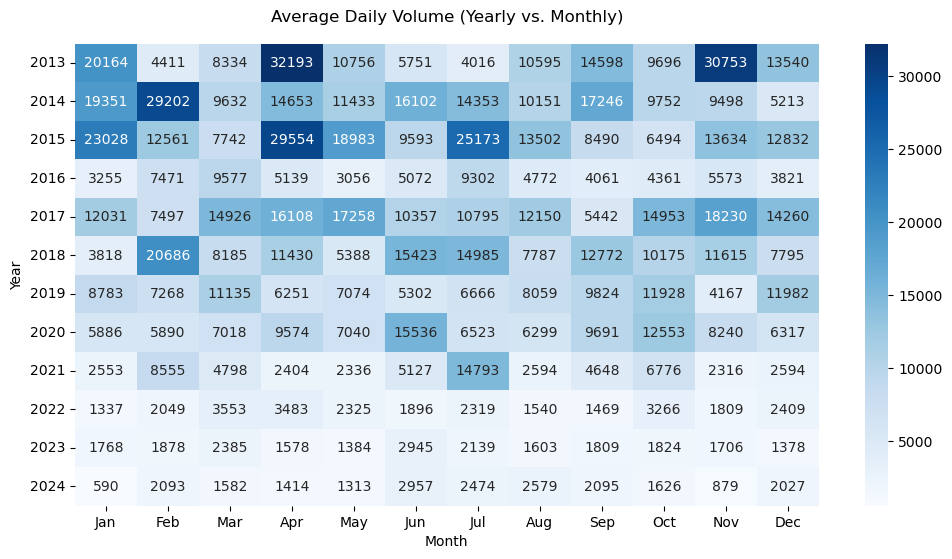

In [23]:
def plot_calendar_map(prices):
    prices = prices.with_columns([
        pl.col("Date").dt.year().alias('year'),
        pl.col("Date").dt.month().alias('month'),
        pl.col("Date").dt.date().alias('day')
    ])

    # aggregate to daily volume
    daily_volume = prices.group_by(['year', 'month', 'day']).agg(
        pl.sum("Volume").alias("daily_volume")
    )

    # calculate average daily volume per month for each year
    avg_monthly_volume = daily_volume.group_by(['year', 'month']).agg(
        pl.mean("daily_volume").alias("avg_daily_volume")
    )

    heatmap_data = avg_monthly_volume.pivot(
        on='month', 
        index='year', 
        values='avg_daily_volume'
    ).sort(by="year").to_pandas()

    heatmap_data = heatmap_data.set_index('year')
    heatmap_data.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_data, cmap="Blues", annot=True, fmt=".0f")
    plt.title('Average Daily Volume (Yearly vs. Monthly)', y=1.03)
    plt.xlabel('Month')
    plt.ylabel('Year')
    plt.yticks(rotation=0)
    plt.show()

plot_calendar_map(bitcoin_1min)

### **Resampling**

In [6]:
def resample_ohlcv(prices, freq):
    """
    Resample OHLCV data to a specified frequency.

    Args:
        prices (pl.DataFrame): The Polars DataFrame containing OHLCV data.
        freq (str): The resampling frequency (e.g., '5m', '10m', '15m').

    Returns:
        pl.DataFrame: Resampled OHLCV DataFrame.
    """
    return prices.group_by(
        pl.col("Date").dt.truncate(freq)
    ).agg([
        pl.col("Open").first().alias("Open"),
        pl.col("High").max().alias("High"),
        pl.col("Low").min().alias("Low"),
        pl.col("Close").last().alias("Close"),
        pl.col("Volume").sum().alias("Volume")
    ]).sort("Date")

freqs = ["5m", "10m", "15m"]
resampled_bitcoin = {"bitcoin_1m": bitcoin_1min}

for freq in freqs:
    resampled_bitcoin[f"bitcoin_{freq}"] = resample_ohlcv(bitcoin_1min, freq)

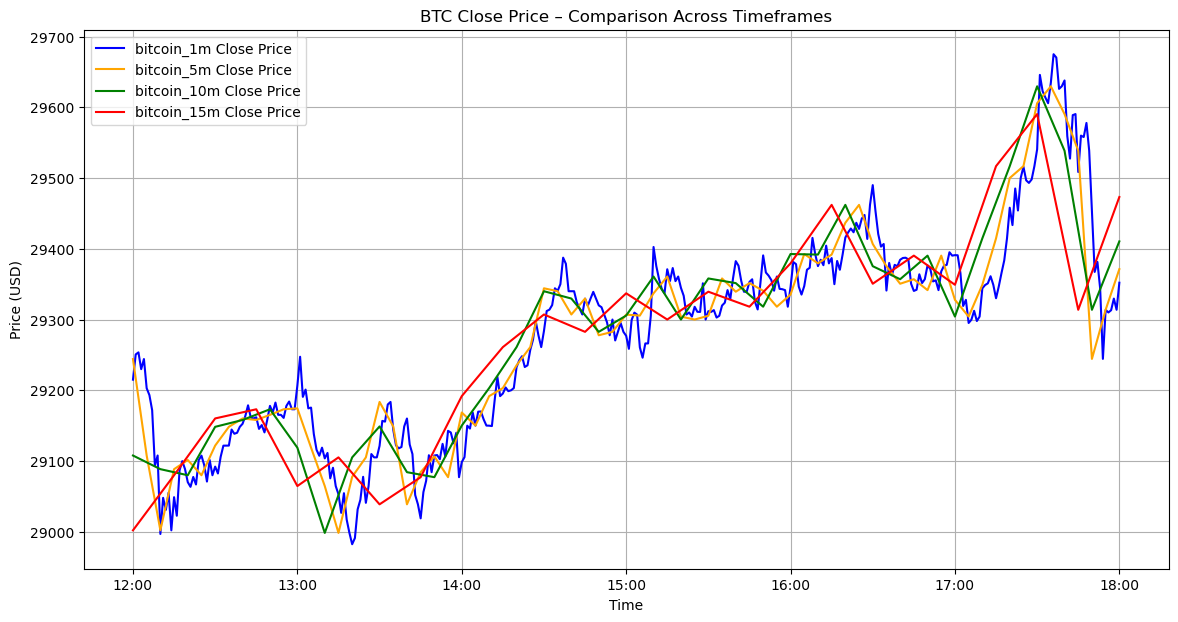

In [7]:
COLOR_MAP = {
    "bitcoin_1m": "blue",
    "bitcoin_5m": "orange",
    "bitcoin_10m": "green",
    "bitcoin_15m": "red"
}

def plot_resampled(resampled_data, start, end):
    """
    Plot BTC price data across multiple timeframes to visualize smoothing trends.
    
    Args:
        resampled_data (dict): Dictionary of resampled Polars DataFrames (5min, 10min, etc.).
        start (datetime): Start datetime for the plot.
        end (datetime): End datetime for the plot.
    """
    plt.figure(figsize=(14, 7))

    for freq, df in resampled_data.items():
        subset = df.filter(
            (pl.col("Date") >= start) & (pl.col("Date") <= end)
        ).select("Date", "Close")
        
        plt.plot(
            subset.select("Date"), subset.select("Close"), 
            color=COLOR_MAP.get(freq, "blue"),
            label=f"{freq} Close Price",
        )

    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.title("BTC Close Price – Comparison Across Timeframes")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

start = datetime(2021, 1, 1, 12)
end = start + timedelta(hours=6)
plot_resampled(resampled_bitcoin, start=start, end=end)

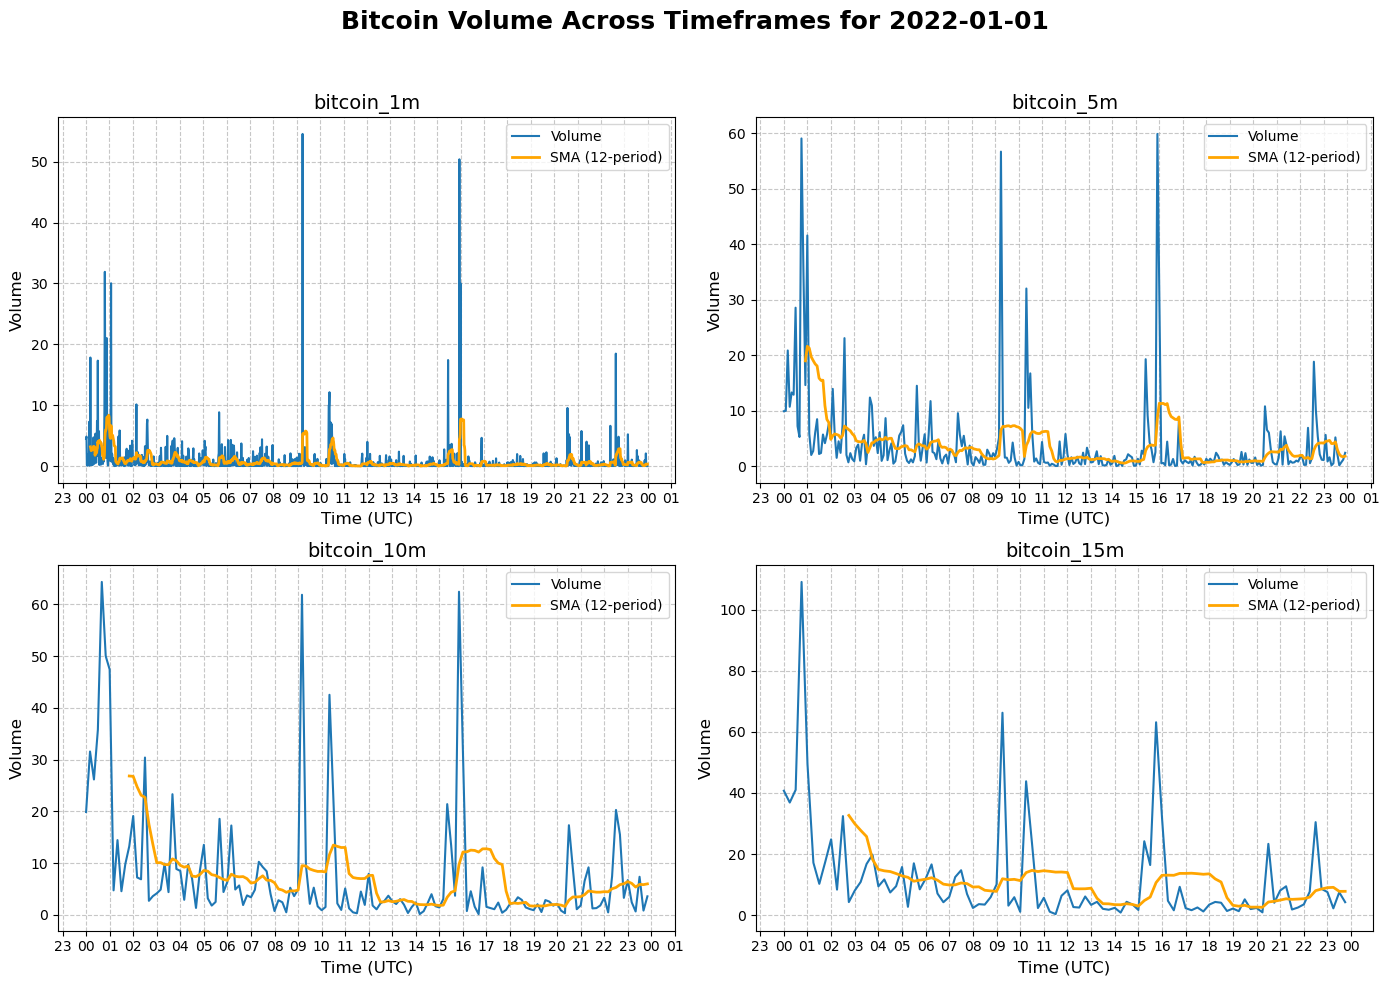

In [ ]:
def plot_volume_day_resampled(resampled_data, day, window_sizes=None):
    """
    Plot Bitcoin volume and SMAs for a specific day across different resampled dataframes.

    Args:
        resampled_data (dict): Dictionary of Polars DataFrames with resampled OHLCV data.
        day (datetime): Date to filter and plot.
        window_sizes (dict): Custom window sizes for each resampling period.
    """
    window_sizes = {} if window_sizes is None else window_sizes
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for ax, (freq, df) in zip(axes, resampled_data.items()):
        window_size = window_sizes.get(freq, 12)  

        filtered_prices = df.filter(
            pl.col("Date").dt.date() == day.date()
        ).with_columns(
            pl.col("Volume").rolling_mean(window_size=window_size).alias("SMA_1h")
        ).select("Date", "Volume", "SMA_1h").to_pandas()

        # Plot volume and SMA
        ax.plot(filtered_prices["Date"], filtered_prices["Volume"], linewidth=1.5, label='Volume')
        ax.plot(filtered_prices["Date"], filtered_prices["SMA_1h"], color='orange', linewidth=2, label=f"SMA ({window_size}-period)")

        ax.set_title(f"{freq}", fontsize=14)
        ax.set_xlabel("Time (UTC)", fontsize=12)
        ax.set_ylabel("Volume", fontsize=12)
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(loc="upper right")

    plt.suptitle(f"Bitcoin Volume Across Timeframes for {day.strftime('%Y-%m-%d')}", fontsize=18, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

window_sizes = {
    "bitcoin_1m": 60,   # 1-hour SMA (60 x 1m = 60m)
    "bitcoin_5m": 12,   # 1-hour SMA (12 x 5m = 60m)
    "bitcoin_10m": 6,   # 1-hour SMA (6 x 10m = 60m)
    "bitcoin_15m": 4,   # 1-hour SMA (4 x 15m = 60m)
}
day = datetime(2022, 1, 1)
plot_volume_day_resampled(resampled_bitcoin, day)

Intraday volume displays frequent spikes which may not be deseribale from a modelling perspective.

### **Log Returns**

In [7]:
def calculate_log_returns(prices, col_name="Close"):
    """
    Calculate log returns for a given price column in a Polars DataFrame.

    Args:
        prices (pl.DataFrame): Polars DataFrame containing OHLC data.
        col_name (str): The column to compute log returns from (default is 'Close').

    Returns:
        pl.DataFrame: DataFrame with an additional 'log_returns' column.
    """
    return prices.with_columns(
        (pl.col(col_name) / pl.col(col_name).shift(1)).log().alias("log_returns")
    ).filter(
        pl.col("log_returns").is_not_null()
    )

for freq, df in resampled_bitcoin.items():
    resampled_bitcoin[freq] = calculate_log_returns(df)

desc_stats = []
statistic_column = None

for freq, df in resampled_bitcoin.items():
    desc = df.select("log_returns").describe()
    
    if statistic_column is None:
        statistic_column = desc.select("statistic")
    desc = desc.select("log_returns").rename({"log_returns": f"{freq} Log Returns"})
    desc_stats.append(desc)

combined_desc = pl.concat([statistic_column] + desc_stats, how="horizontal")
print(combined_desc)

shape: (9, 5)
┌────────────┬────────────────┬────────────────┬─────────────────────────┬─────────────────────────┐
│ statistic  ┆ bitcoin_1m Log ┆ bitcoin_5m Log ┆ bitcoin_10m Log Returns ┆ bitcoin_15m Log Returns │
│ ---        ┆ Returns        ┆ Returns        ┆ ---                     ┆ ---                     │
│ str        ┆ ---            ┆ ---            ┆ f64                     ┆ f64                     │
│            ┆ f64            ┆ f64            ┆                         ┆                         │
╞════════════╪════════════════╪════════════════╪═════════════════════════╪═════════════════════════╡
│ count      ┆ 6.729279e6     ┆ 1.345902e6     ┆ 672974.0                ┆ 448679.0                │
│ null_count ┆ 0.0            ┆ 0.0            ┆ 0.0                     ┆ 0.0                     │
│ mean       ┆ 0.000001       ┆ 0.000007       ┆ 0.000015                ┆ 0.000022                │
│ std        ┆ 0.001853       ┆ 0.003558       ┆ 0.004821                ┆ 0.

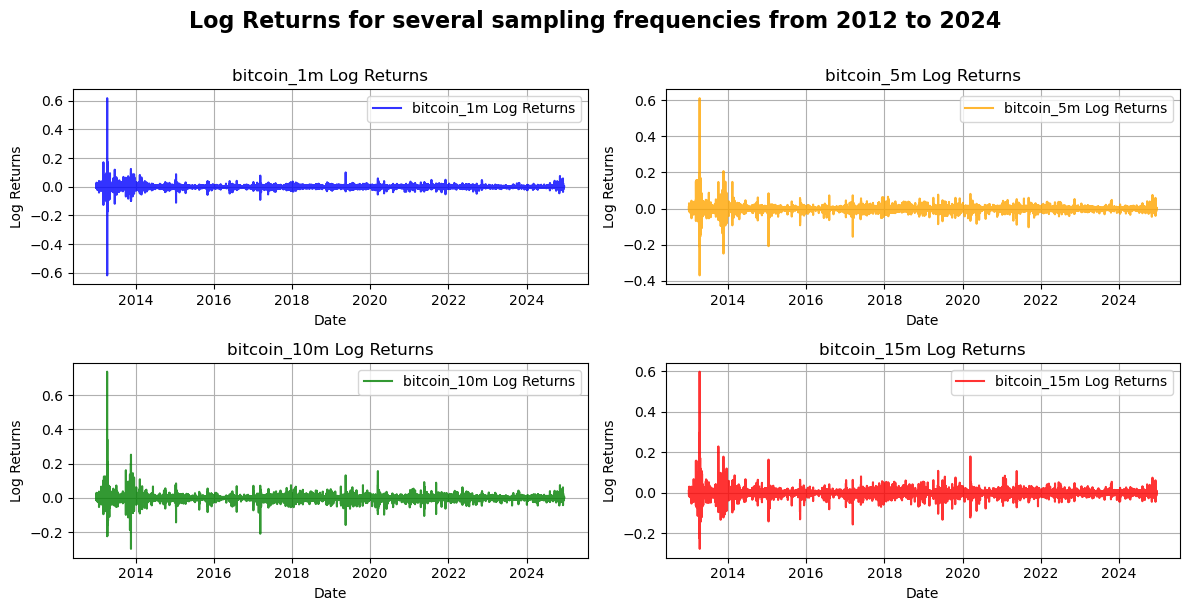

In [ ]:
def plot_log_returns_resampled(resampled_data, start=None, end=None):
    """
    Plot log returns as line plots for different timeframes in a 2x2 grid.

    Args:
        resampled_data (dict): Dictionary of Polars DataFrames with log returns.
        start (datetime, optional): Start date for filtering the data.
        end (datetime, optional): End date for filtering the data.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    plt.suptitle("Log Returns for several sampling frequencies from 2012 to 2024", 
                 fontsize=16, fontweight="bold", y=1.01)
    axes = axes.flatten()

    for ax, (freq, data) in zip(axes, resampled_data.items()):
        if start is not None:
            data = data.filter(pl.col("Date") >= start)
        if end is not None:
            data = data.filter(pl.col("Date") <= end)
        
        ax.plot(
            data.select("Date"), data.select("log_returns"), 
            label=f"{freq} Log Returns", color=COLOR_MAP.get(freq, "blue"), alpha=0.8
        )
        
        ax.set_title(f"{freq} Log Returns")
        ax.set_xlabel("Date")
        ax.set_ylabel("Log Returns")
        ax.legend()
        ax.grid(True)

    fig.tight_layout()
    plt.show()

plot_log_returns_resampled(resampled_bitcoin)

As you can see **1-min log rteurns** show little variation while other lower frequencies show much more volatility whihc might indictae a poential more relevence for momentum trading as in momnetum trading we are lookign for stronger movements.

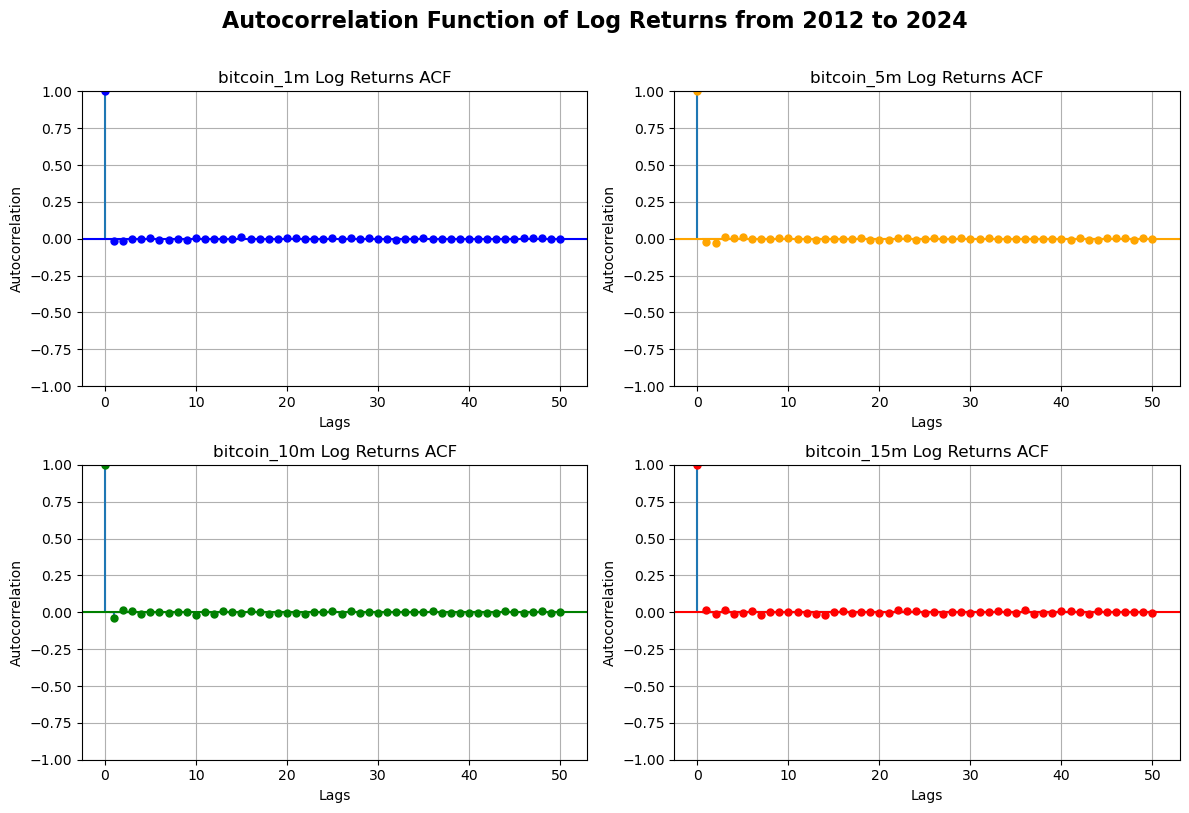

In [49]:
def plot_acf_resampled(resampled_data, start=None, end=None, lags=50):
    """
    Plot ACF (Autocorrelation) for log returns of different resampled DataFrames.

    Args:
        resampled_data (dict): Dictionary of Polars DataFrames with log returns.
        start (datetime, optional): Start date for filtering the data.
        end (datetime, optional): End date for filtering the data.
        lags (int): Number of lags to display in the ACF plot.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    plt.suptitle("Autocorrelation Function of Log Returns from 2012 to 2024", fontsize=16, fontweight="bold", y=1.01)
    axes = axes.flatten()

    for ax, (freq, data) in zip(axes, resampled_data.items()):
        if start is not None:
            data = data.filter(pl.col("Date") >= start)
        if end is not None:
            data = data.filter(pl.col("Date") <= end)
        
        plot_acf(
            data.select("log_returns"), lags=lags, ax=ax, 
            title=f"{freq} Log Returns ACF", 
            color=COLOR_MAP.get(freq, "gray")
        )
        
        ax.grid(True)
        ax.set_xlabel("Lags")
        ax.set_ylabel("Autocorrelation")

    fig.tight_layout()
    plt.show()

start = datetime(2022, 1, 1)
end = datetime(2023, 1, 1)
plot_acf_resampled(resampled_bitcoin, start=start, end=end)

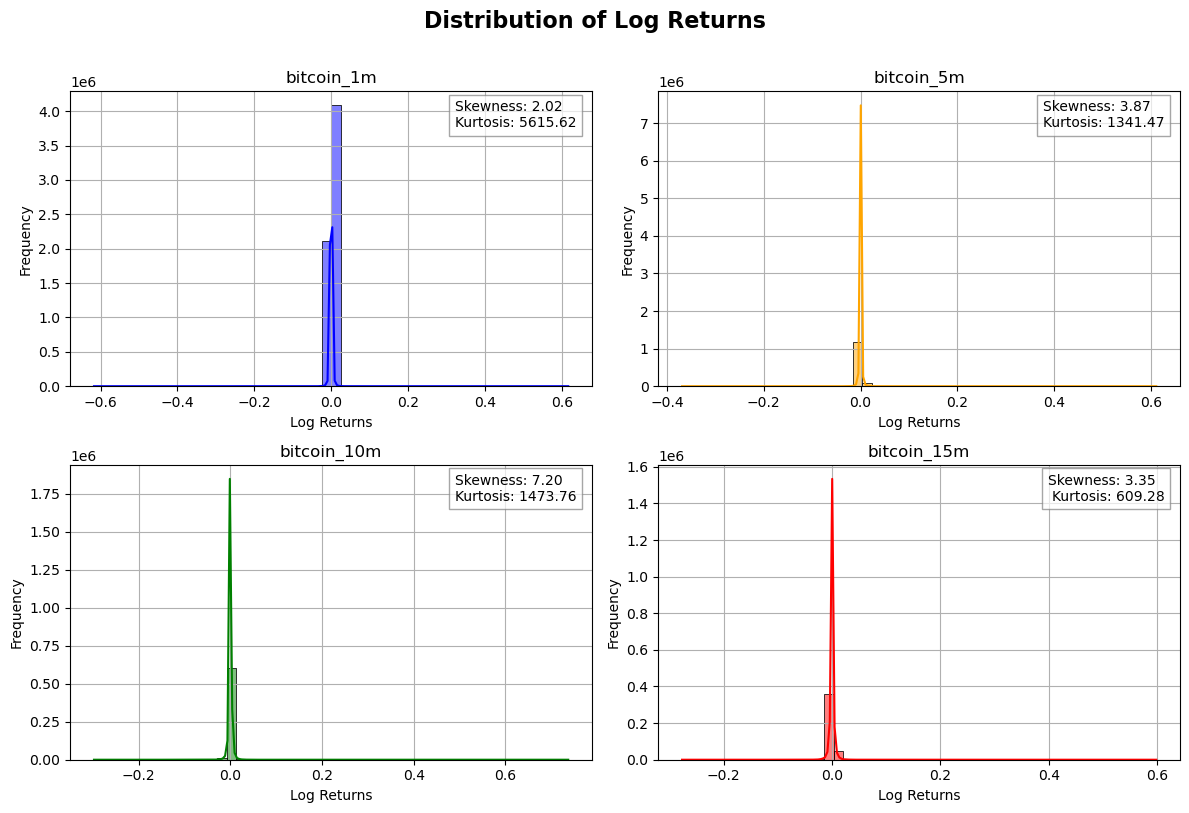

In [52]:
def plot_histograms(resampled_data, col_name, bins=50, stats=False):
    """
    Plot 2x2 grid of histograms for log returns of different resampled DataFrames,
    with skewness and kurtosis displayed in the top-right corner.

    Args:
        resampled_data (dict): Dictionary of Polars DataFrames with log returns.
        bins (int): Number of bins for histograms.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    col_name_str = " ".join([name.capitalize() for name in col_name.split("_")])
    plt.suptitle(f"Distribution of {col_name_str}", fontsize=16, fontweight="bold", y=1.01)

    for ax, (freq, data) in zip(axes, resampled_data.items()):
        sns.histplot(
            data[col_name], kde=True, bins=bins, 
            color=COLOR_MAP.get(freq, "gray"), ax=ax
        )
        
        ax.set_title(f"{freq}")
        ax.set_xlabel(f"{col_name_str}")
        ax.set_ylabel("Frequency")
        ax.grid(True)
        
        if stats:
            skewness = skew(data.select(col_name).to_series())
            kurt = kurtosis(data.select(col_name).to_series())
            
            skew_str = f"Skewness: {skewness:.2f}"
            kurt_str = f"Kurtosis: {kurt:.2f}"

            max_length = max(len(skew_str), len(kurt_str))
            skew_str = skew_str.ljust(max_length)
            kurt_str = kurt_str.ljust(max_length)
            textstr = f"{skew_str}\n{kurt_str}"

            ax.text(0.97, 0.97, textstr, transform=ax.transAxes,
                    fontsize=10, verticalalignment='top', horizontalalignment='right',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

    
    fig.tight_layout()
    plt.show()

plot_histograms(resampled_bitcoin, "log_returns", stats=True)

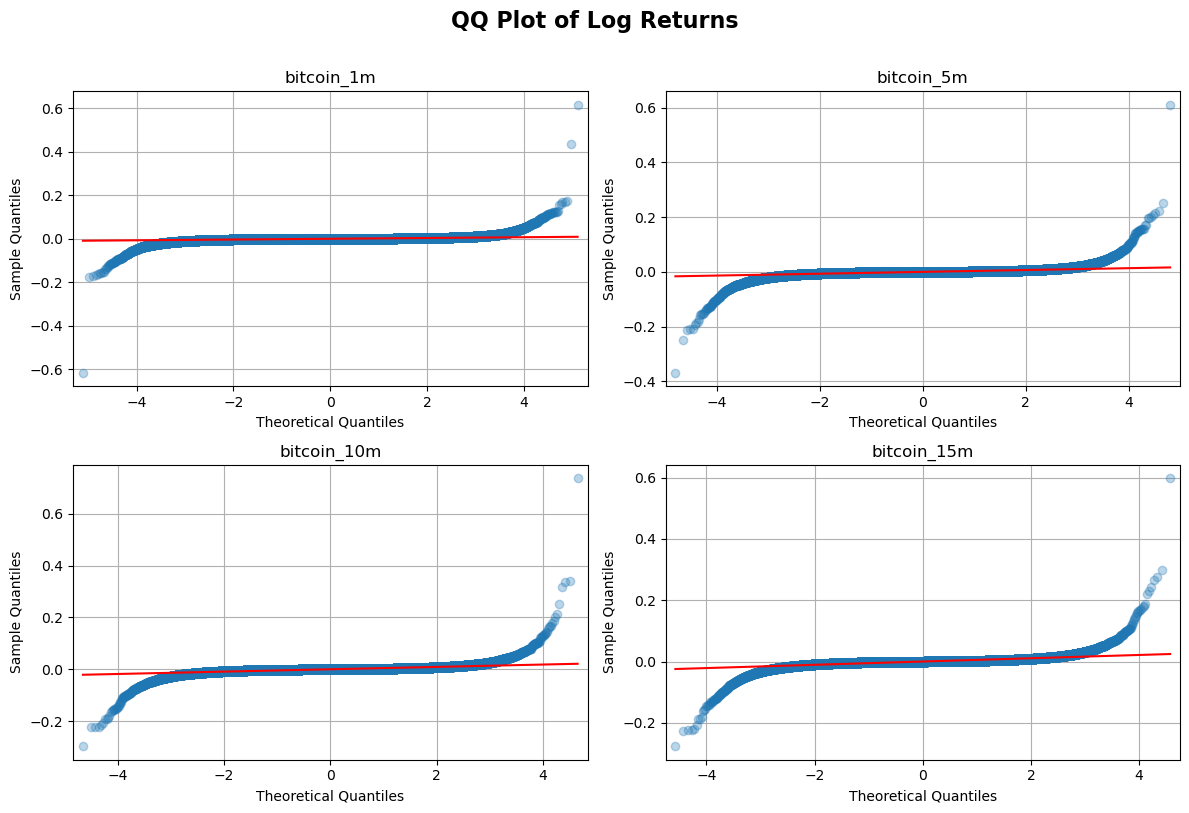

In [53]:
def plot_qq_plots_resampled(resampled_data, col_name):
    """
    Plot a 2x2 grid of QQ plots for log returns of different resampled DataFrames.

    Args:
        resampled_data (dict): Dictionary of Polars DataFrames with log returns.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    col_name_str = " ".join([name.capitalize() for name in col_name.split("_")])
    plt.suptitle(f"QQ Plot of {col_name_str}", fontsize=16, fontweight="bold", y=1.01)

    for ax, (interval, df) in zip(axes, resampled_data.items()):
        qqplot(df.select(col_name).to_series(), line="s", ax=ax, alpha=0.3)
        ax.set_title(f"{interval}")
        ax.set_xlabel("Theoretical Quantiles")
        ax.set_ylabel("Sample Quantiles")
        ax.grid(True)

    fig.tight_layout()
    plt.show()

plot_qq_plots_resampled(resampled_bitcoin, "log_returns")

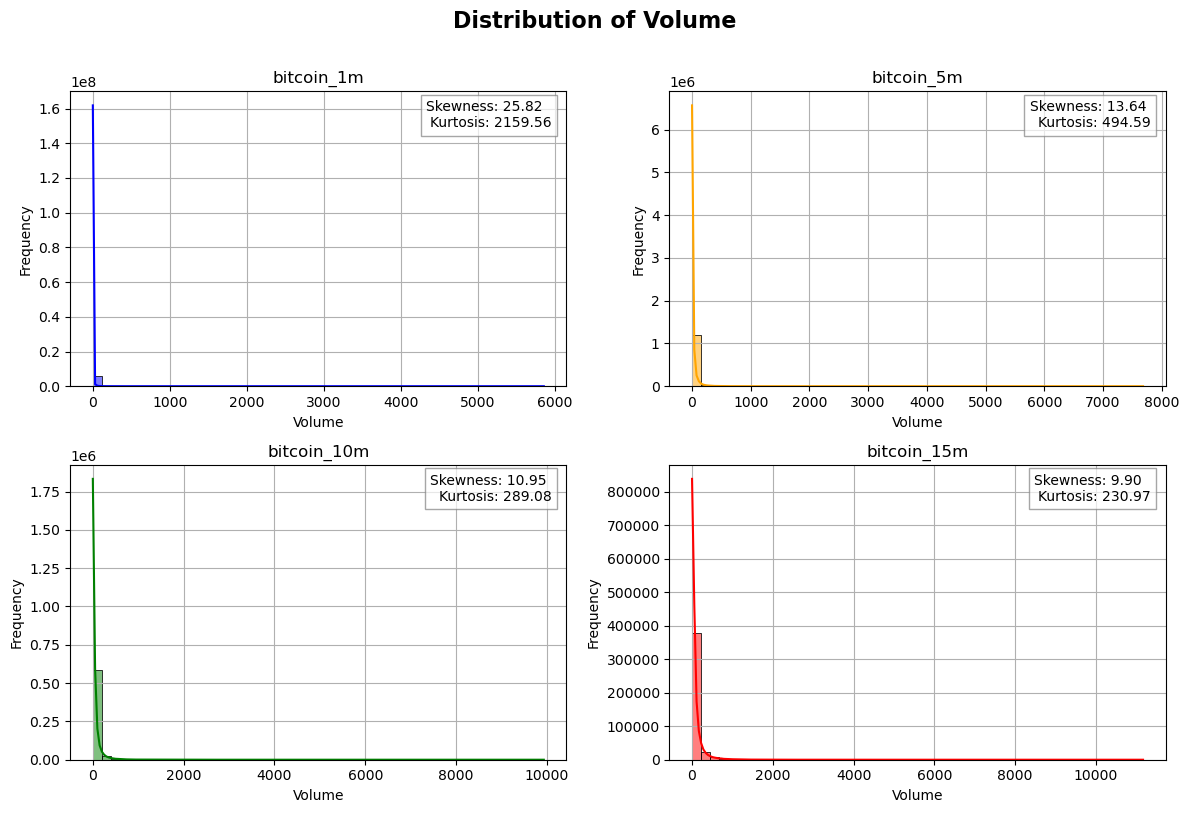

In [54]:
plot_histograms(resampled_bitcoin, "Volume", stats=True)

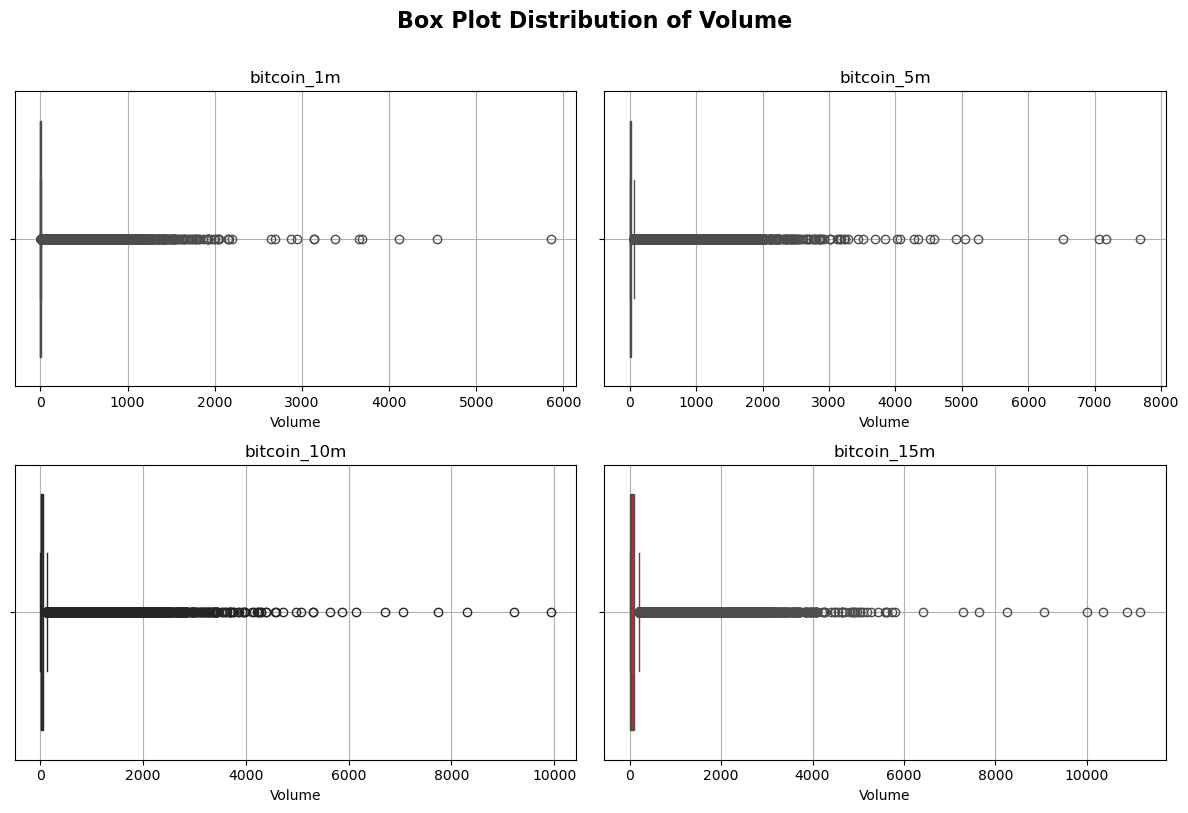

In [55]:
def plot_boxplots(resampled_data, col_name):
    """
    Plot 2x2 grid of box plots for volume or log returns of different resampled DataFrames,
    with skewness and kurtosis displayed in the top-right corner.

    Args:
        resampled_data (dict): Dictionary of Polars DataFrames.
        col_name (str): Name of the column to plot (e.g., "Volume", "log_returns").
        stats (bool): Whether to display skewness and kurtosis on the plots.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    col_name_str = " ".join([name.capitalize() for name in col_name.split("_")])
    plt.suptitle(f"Box Plot Distribution of {col_name_str}", fontsize=16, fontweight="bold", y=1.01)

    for ax, (freq, data) in zip(axes, resampled_data.items()):
        sns.boxplot(x=data[col_name], ax=ax, color=COLOR_MAP.get(freq, "skyblue"))
        ax.set_title(f"{freq}")
        ax.set_xlabel(f"{col_name_str}")
        ax.grid(True)
        

    fig.tight_layout()
    plt.show()

plot_boxplots(resampled_bitcoin, "Volume")

### **Conclusion: The choice of Sampling Frequency**

To strike a balance between data quality and quantity for training deep learning models, we will use **5-minute Bitcoin observations**. This resampling reduces the noise present in 1-minute data while preserving sufficient detail. As a result, we retain approximately **1.4 million observations** which is a reasonbale size for considering deep learning models. Thus in the next sections we will only consider the 5-minutes frequency.

In [1161]:
resampled_bitcoin

{'bitcoin_1m': shape: (6_729_279, 7)
 ┌─────────────────────┬──────────┬──────────┬──────────┬──────────┬───────────┬─────────────┐
 │ Date                ┆ Open     ┆ High     ┆ Low      ┆ Close    ┆ Volume    ┆ log_returns │
 │ ---                 ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---       ┆ ---         │
 │ datetime[μs]        ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64       ┆ f64         │
 ╞═════════════════════╪══════════╪══════════╪══════════╪══════════╪═══════════╪═════════════╡
 │ 2012-01-01 10:02:00 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 0.0       ┆ 0.0         │
 │ 2012-01-01 10:03:00 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 0.0       ┆ 0.0         │
 │ 2012-01-01 10:04:00 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 0.0       ┆ 0.0         │
 │ 2012-01-01 10:05:00 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 0.0       ┆ 0.0         │
 │ 2012-01-01 10:06:00 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 0.0       ┆ 0.0         │
 │ …         

In [1160]:
resampled_bitcoin[f"bitcoin_30m"] = resample_ohlcv(bitcoin_1min, "30m")

In [1313]:
bitcoin = resampled_bitcoin["bitcoin_5m"]

## **Features**

### **Technical indicators Features**

In [1583]:
def create_technical_indicators_features(prices, windows=[7, 14, 21, 50, 100]):
    """
    Extract technical indicators (SMA, EMA, MACD, RSI, ATR, Bollinger Bands) 
    from a Polars DataFrame using TA-Lib.

    Args:
        prices (pl.DataFrame): Polars DataFrame with OHLCV data.
        windows (list): List of window sizes for technical indicators.

    Returns:
        pl.DataFrame: Polars DataFrame with TA-Lib indicators for each window.
    """
    close = prices["Close"]
    high = prices['High']
    low = prices['Low']

    indicator_columns = []

    # Moving Average Convergence Divergence
    macd, macd_signal, _ = ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    indicator_columns.extend([
        pl.Series('MACD', macd),
        pl.Series('MACD_signal', macd_signal)
    ])

    for window in windows:
        # Simple and Exponetial Moving Averages
        sma = ta.SMA(close, timeperiod=window)
        ema = ta.EMA(close, timeperiod=window)
        
        # Bollinger Bands
        bb_upper, _, bb_lower = ta.BBANDS(close, timeperiod=window, nbdevup=2, nbdevdn=2)
        
        # Relative Strength Index
        rsi = ta.RSI(close, timeperiod=window)

        # Average Directional Index
        adx = ta.ADX(high, low, close, timeperiod=window)

        # Average True Range
        atr = ta.ATR(high, low, close, timeperiod=window)

        # Rate of Change
        roc = ta.ROCP(close, timeperiod=window)
        
        indicator_columns.extend([
            pl.Series(f'SMA_{window}', sma),
            pl.Series(f'EMA_{window}', ema),
            pl.Series(f'RSI_{window}', rsi),
            pl.Series(f'ADX_{window}', adx),
            pl.Series(f'ATR_{window}', atr),
            pl.Series(f'ROC{window}', roc),
            pl.Series(f'BB_upper_{window}', bb_upper),
            pl.Series(f'BB_lower_{window}', bb_lower)
        ])
    prices = prices.with_columns(indicator_columns)
    prices = prices.with_columns(
        (pl.col("SMA_7") - pl.col("SMA_21")).alias("SMA_cross_7_21")
    )
    return prices

### **Priced based Features (Trend/Momentum)**

In [1584]:
def create_price_features(prices, windows=[7, 14, 21, 50, 100]):
    """
    Extract price-based features (momentum, log returns, rolling stats) 
    from a Polars DataFrame using multiple window sizes.
    """
    features = []
    prices = prices.with_columns(
        (pl.col("Close") / pl.col("Close").shift(1)).log().alias('log_returns')
    )
    
    for window in windows:
        features.extend([
            pl.col('log_returns').rolling_mean(window_size=window).alias(f'mean_log_returns_{window}'),
            pl.col('log_returns').rolling_std(window_size=window).alias(f'std_log_returns_{window}'),
            (pl.col("Close") - pl.col("Close").shift(window)).alias(f'momentum_{window}'),
            pl.col("Close").rolling_max(window_size=window).alias(f'rolling_max_{window}'),
            pl.col("Close").rolling_min(window_size=window).alias(f'rolling_min_{window}'),
            pl.col("Close").rolling_skew(window_size=window).alias(f'price_skew_{window}')
        ])
    
    prices = prices.with_columns(features)
    return prices

### **Volume Features**

In [1585]:
def create_volume_features(prices, windows=[7, 14, 21, 50, 100]):
    """
    Extracts volume-based features (VWAP, OBV, Chaikin Money Flow) 
    for multiple rolling windows from a Polars DataFrame with OHLCV data.

    Args:
        prices (pl.DataFrame): Polars DataFrame with OHLCV data.
        windows (list): List of window sizes to compute rolling indicators.

    Returns:
        pl.DataFrame: Polars DataFrame enriched with volume-based indicators.
    """
    volume_features = []

    # Volume Weighted Average Price
    vwap = (prices['Close'] * prices['Volume']).cum_sum() / prices['Volume'].cum_sum()

    # On-Balance Volume
    obv = ta.OBV(prices['Close'], prices['Volume'])

    # Accumulation/Distribution Line
    adl = ta.AD(prices['High'], prices['Low'], prices['Close'], prices['Volume'])

    volume_features.extend([
        pl.Series('VWAP', vwap),
        pl.Series('OBV', obv),
        pl.Series('ADL', adl)
    ])

    for window in windows:
        # On-Balance Volume
        mfi = ta.MFI(prices['High'], prices['Low'], prices['Close'], prices['Volume'], timeperiod=window)

        # Rolling Average and Volatility of Volume
        rolling_vol_mean = prices['Volume'].rolling_mean(window_size=window)
        rolling_vol_std = prices['Volume'].rolling_std(window_size=window)

        volume_features.extend([
            mfi.alias(f'MFI_{window}'),
            rolling_vol_mean.alias(f'mean_volume_{window}'),
            rolling_vol_std.alias(f'std_volume_{window}')
        ])

    prices = prices.with_columns(volume_features)
    return prices

### **Time-based Features**

In [1586]:
def create_time_features(prices):
    """
    Extracts time-based features (fractional hour, fractional day_of_week),
    plus cyclical sin/cos for hour_of_day and day_of_week, from a Polars DataFrame
    with OHLCV data containing a 'Date' column of type datetime.

    Returns:
        pl.DataFrame: Polars DataFrame enriched with time-based features.
    """
    prices = prices.with_columns(
        pl.col("Date").dt.hour().alias("hour"),
        pl.col("Date").dt.minute().alias("minute"),
        pl.col("Date").dt.weekday().alias("day_of_week")
    )

    prices = prices.with_columns(
        (pl.col("hour") + pl.col("minute") / 60.0).alias("fractional_hour")
    )

    # Cyclical hour features
    prices = prices.with_columns(
        (
            (pl.col("fractional_hour") * 2.0 * np.pi / 24.0).sin()
        ).alias("hour_sin"),
        (
            (pl.col("fractional_hour") * 2.0 * np.pi / 24.0).cos()
        ).alias("hour_cos")
    )

    # Cyclycal day of week
    prices = prices.with_columns(
        (
            ((pl.col("day_of_week") + pl.col("fractional_hour") / 24.0) * 2.0 * np.pi / 7.0).sin()
        ).alias("day_sin"),
        (
            ((pl.col("day_of_week") + pl.col("fractional_hour") / 24.0) * 2.0 * np.pi / 7.0).cos()
        ).alias("day_cos")
    )

    # Market session flags
    prices = prices.with_columns(
        ((pl.col("hour") >= 9) & (pl.col("hour") <= 16)).cast(pl.Int8).alias("us_session"),
        ((pl.col("hour") >= 1) & (pl.col("hour") <= 8)).cast(pl.Int8).alias("asia_session"),
        ((pl.col("hour") >= 7) & (pl.col("hour") <= 15)).cast(pl.Int8).alias("eu_session")
    )

    # Weekend flag
    prices = prices.with_columns(
        (pl.col("day_of_week") >= 5).cast(pl.Int8).alias("weekend")  # 5=Sat, 6=Sun
    )
    
    return prices.drop(["hour", "minute", "fractional_hour", "day_of_week"])

In [1587]:
def create_features(prices, windows=[7, 14, 21, 50, 100]):
    orig_features = prices.drop("Date").columns
    prices = create_price_features(prices, windows)
    prices = create_technical_indicators_features(prices, windows)
    prices = create_volume_features(prices, windows)
    prices = create_time_features(prices)
    prices = prices.drop_nans().drop_nulls()
    return prices.drop(orig_features)

features = create_features(bitcoin)

features

shape: (1_275_470, 100)
┌────────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬─────────┐
│ Date       ┆ mean_log_ ┆ std_log_r ┆ momentum_ ┆ … ┆ us_sessio ┆ asia_sess ┆ eu_sessio ┆ weekend │
│ ---        ┆ returns_7 ┆ eturns_7  ┆ 7         ┆   ┆ n         ┆ ion       ┆ n         ┆ ---     │
│ datetime[μ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ i8      │
│ s]         ┆ f64       ┆ f64       ┆ f64       ┆   ┆ i8        ┆ i8        ┆ i8        ┆         │
╞════════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═════════╡
│ 2012-01-02 ┆ 0.004646  ┆ 0.012293  ┆ 0.16      ┆ … ┆ 0         ┆ 1         ┆ 0         ┆ 0       │
│ 03:45:00   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│ 2012-01-02 ┆ 0.004646  ┆ 0.012293  ┆ 0.16      ┆ … ┆ 0         ┆ 1         ┆ 0         ┆ 0       │
│ 03:50:00   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│ 2012-01-02 ┆ 0.004646  ┆ 0.012293  ┆ 0.16      ┆ … ┆ 0         ┆ 1         ┆ 0         ┆ 0       │
│ 03:55:00   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│ 2012-01-02 ┆ 0.004646  ┆ 0.012293  ┆ 0.16      ┆ … ┆ 0         ┆ 1         ┆ 0         ┆ 0       │
│ 04:00:00   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│ 2012-01-02 ┆ 0.004646  ┆ 0.012293  ┆ 0.16      ┆ … ┆ 0         ┆ 1         ┆ 0         ┆ 0       │
│ 04:05:00   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│ …          ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …       │
│ 2024-12-15 ┆ 0.001535  ┆ 0.002702  ┆ 1119.0    ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 1       │
│ 23:40:00   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│ 2024-12-15 ┆ 0.001523  ┆ 0.002707  ┆ 1111.0    ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 1       │
│ 23:45:00   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│ 2024-12-15 ┆ 0.000791  ┆ 0.00291   ┆ 577.0     ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 1       │
│ 23:50:00   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│ 2024-12-15 ┆ -0.000241 ┆ 0.001677  ┆ -176.0    ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 1       │
│ 23:55:00   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│ 2024-12-16 ┆ -0.000283 ┆ 0.001634  ┆ -207.0    ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 0       │
│ 00:00:00   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
└────────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴─────────┘

In [957]:
def plot_distributions(df, cols_per_grid=20):
    start = 0
    start += 1 if isinstance(df, pl.DataFrame) else 0
    
    for i in range(1, len(df.columns), cols_per_grid):
        subset = df.columns[i:i+cols_per_grid]
        
        plt.figure(figsize=(18, 10)) 
        for j, col in enumerate(subset):
            ax = plt.subplot(4, 5, j+1)

            if isinstance(df, pl.DataFrame):
                data = df.select(col).to_series()
            elif isinstance(df, pd.DataFrame):
                data = df[col]
            
            sns.histplot(data, kde=True, bins=100, ax=ax, legend=False)

            skewness = skew(data)
            kurt = kurtosis(data)

            skew_str = f"Skewness: {skewness:.2f}"
            kurt_str = f"Kurtosis: {kurt:.2f}"

            max_length = max(len(skew_str), len(kurt_str))
            skew_str = skew_str.ljust(max_length)
            kurt_str = kurt_str.ljust(max_length)
            textstr = f"{skew_str}\n{kurt_str}"

            ax.text(0.97, 0.97, textstr, transform=ax.transAxes,
                    fontsize=10, verticalalignment='top', horizontalalignment='right',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
            
            plt.xlabel(col)
            plt.title(f'{col}')
        
        plt.tight_layout()
        plt.show()

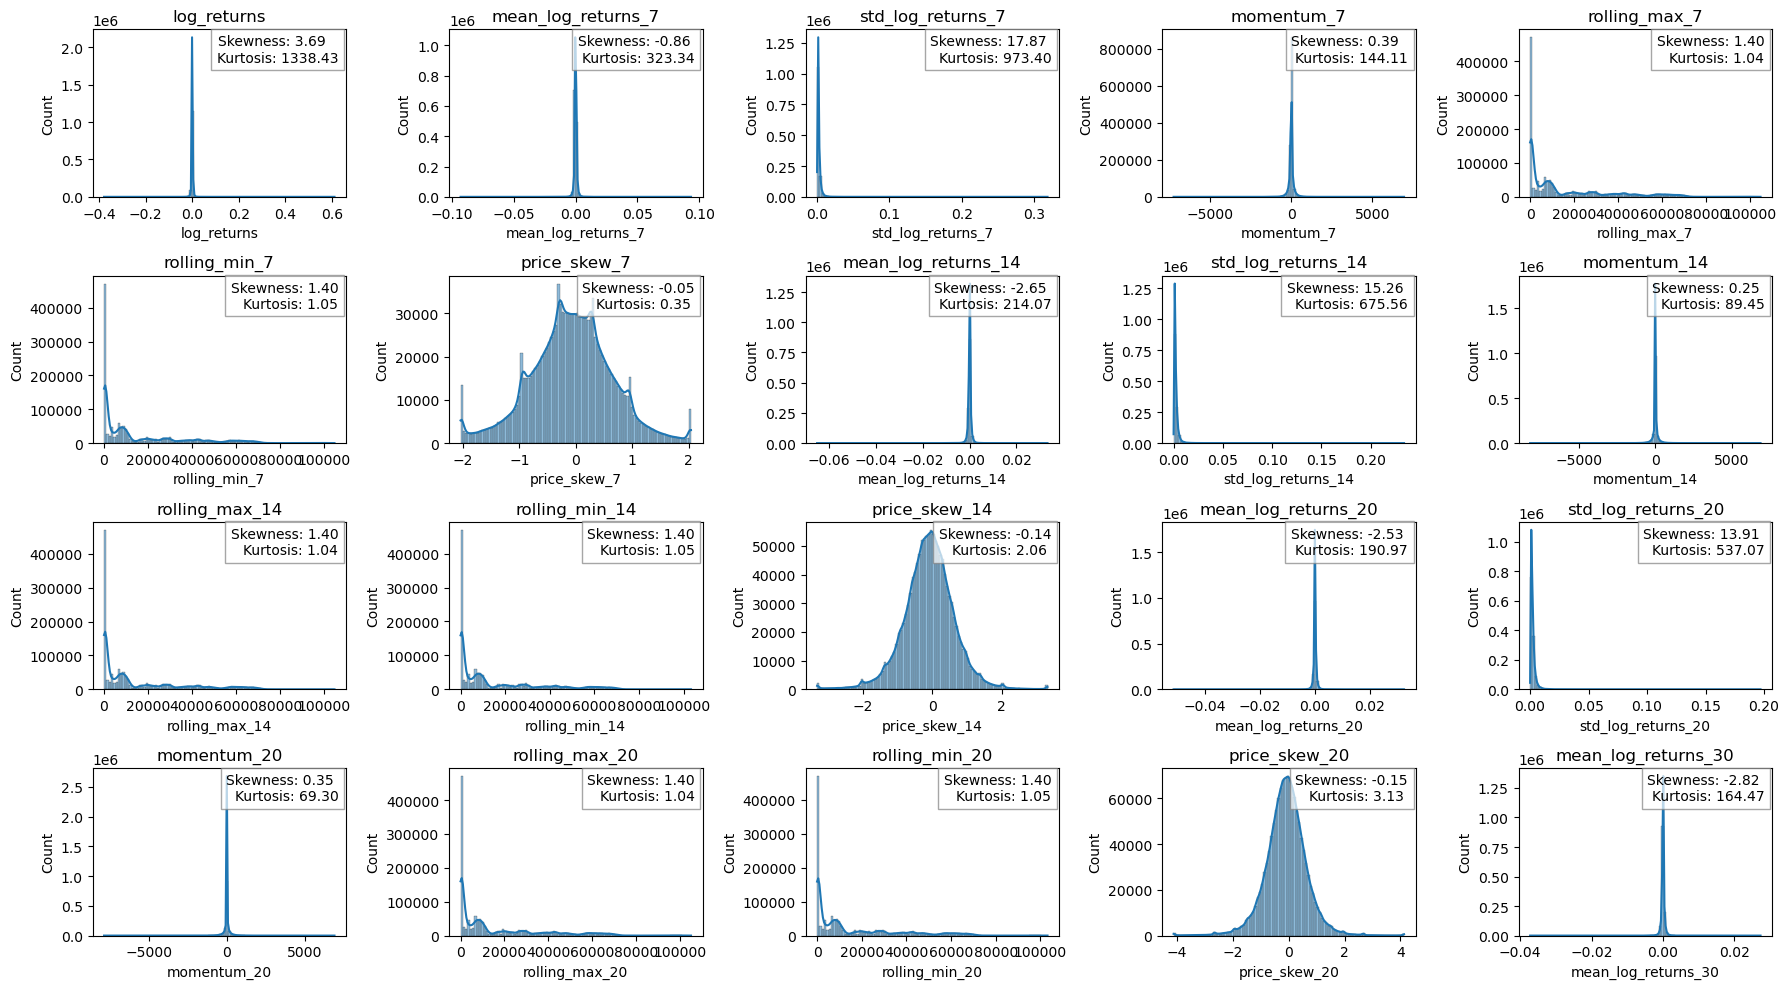

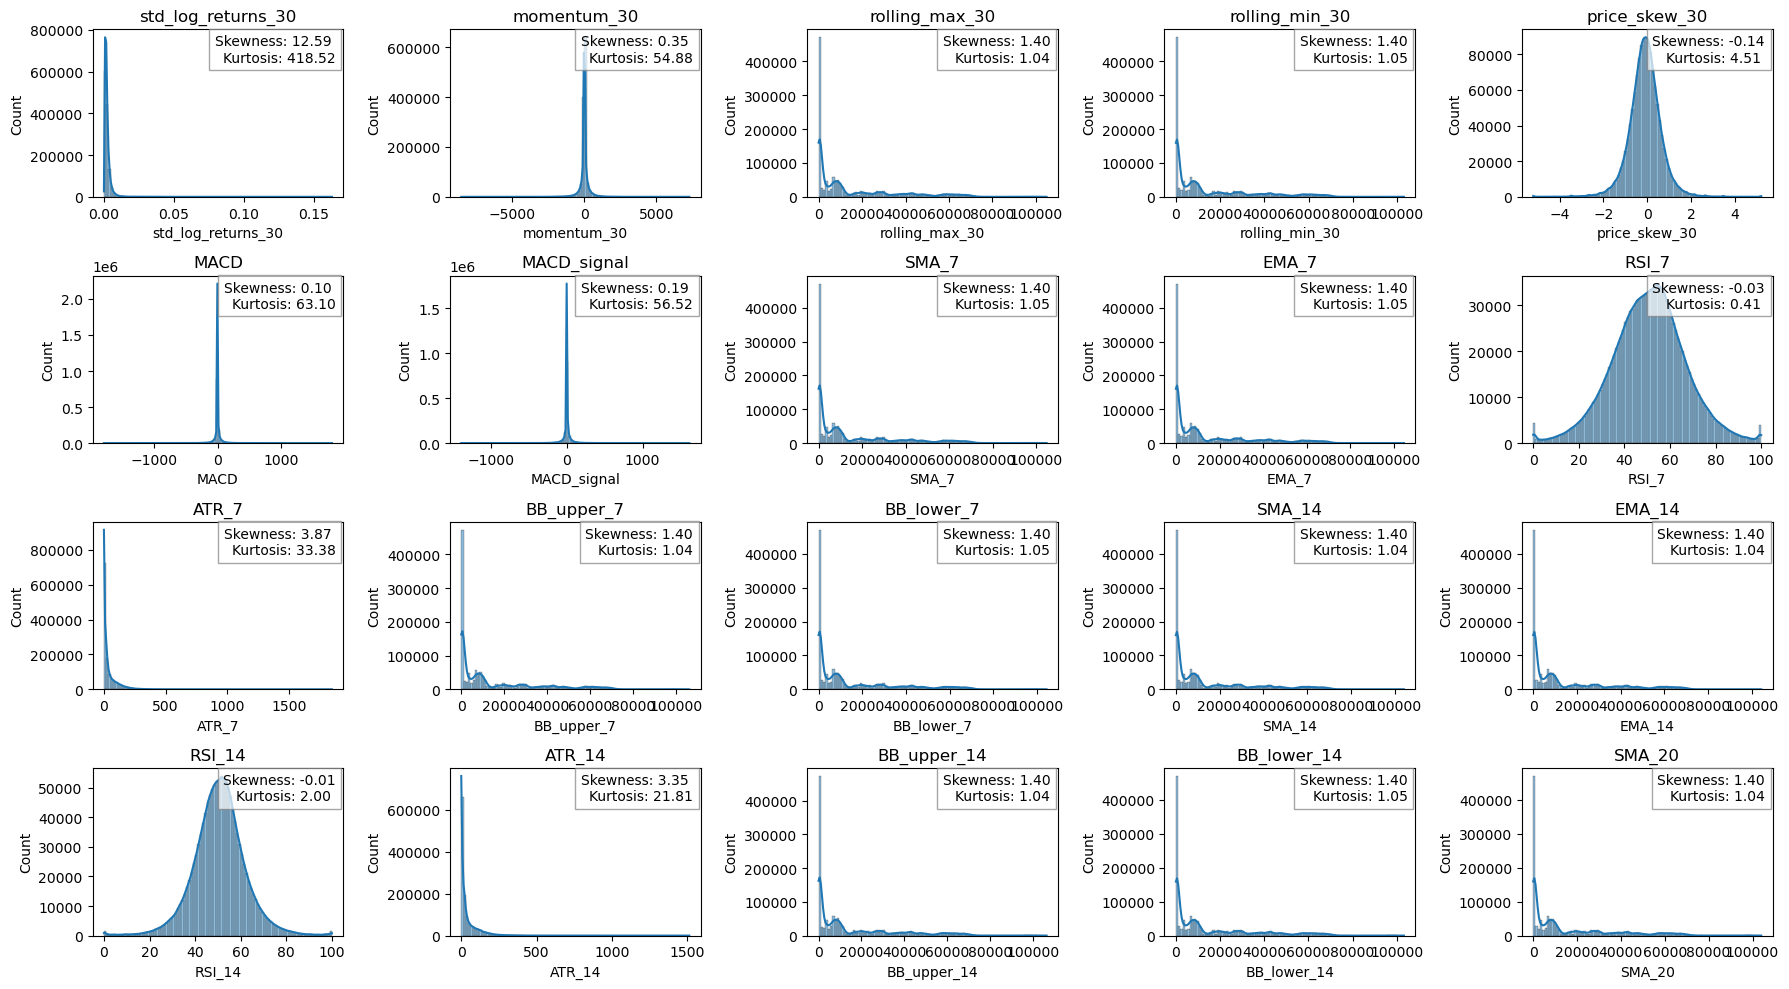

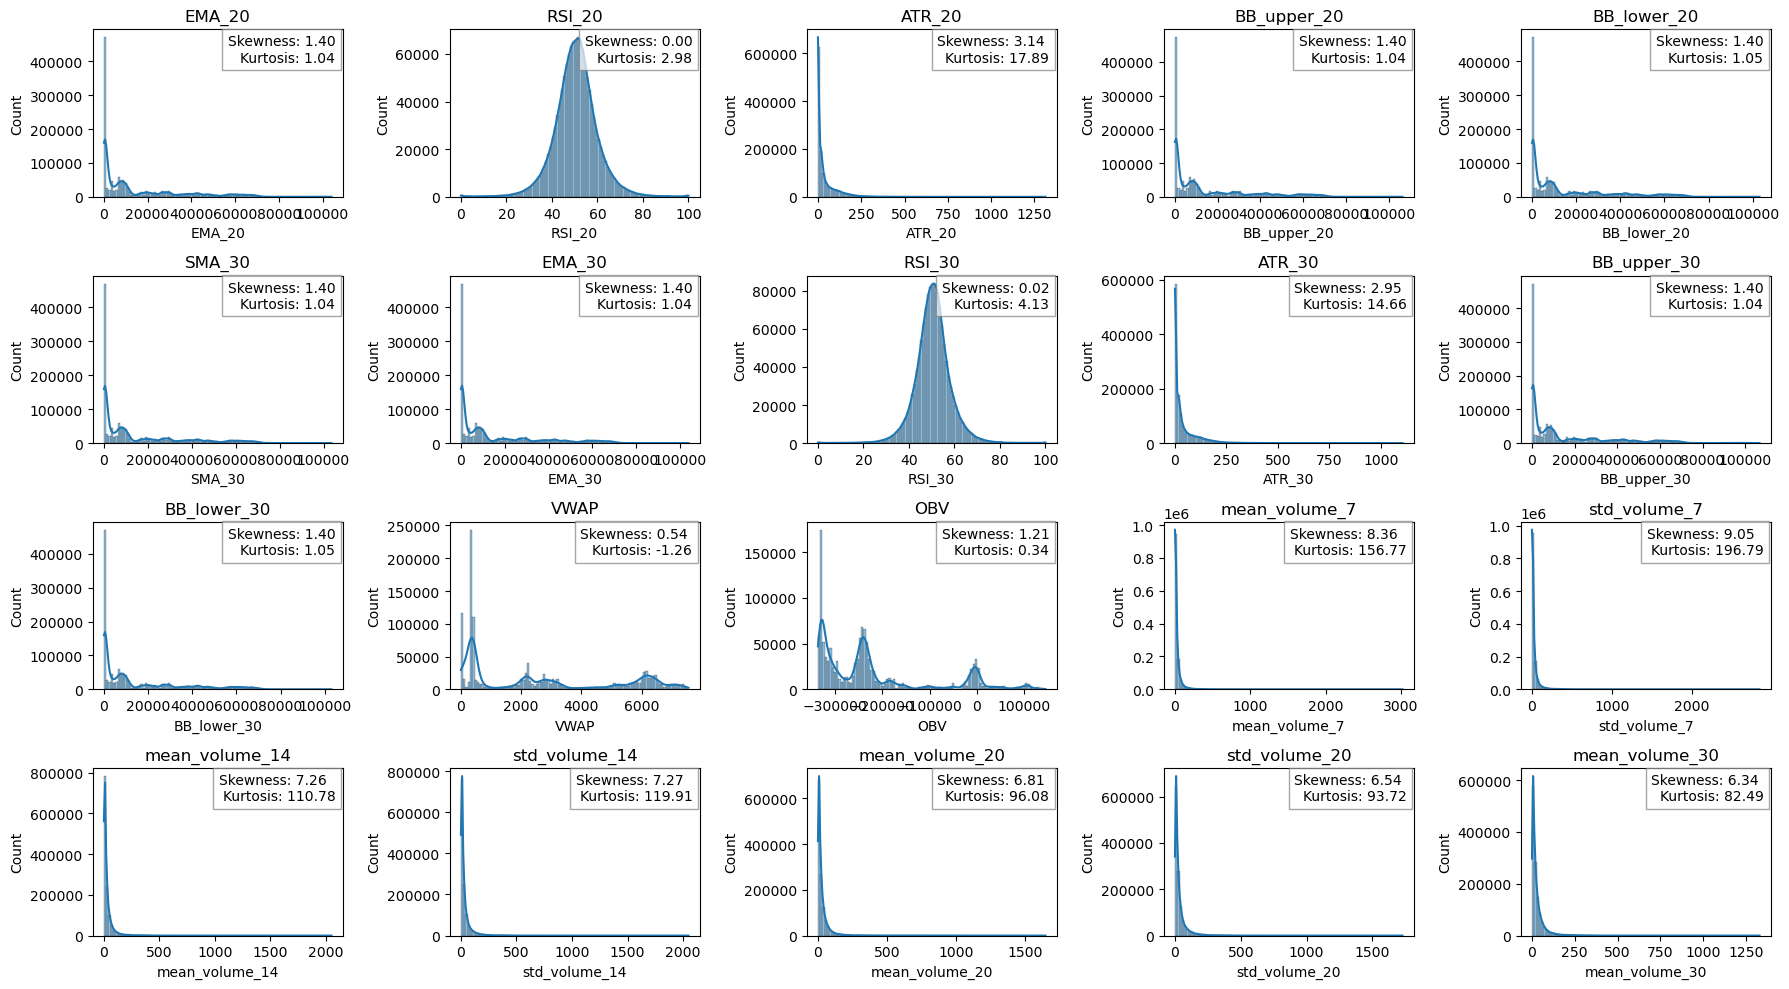

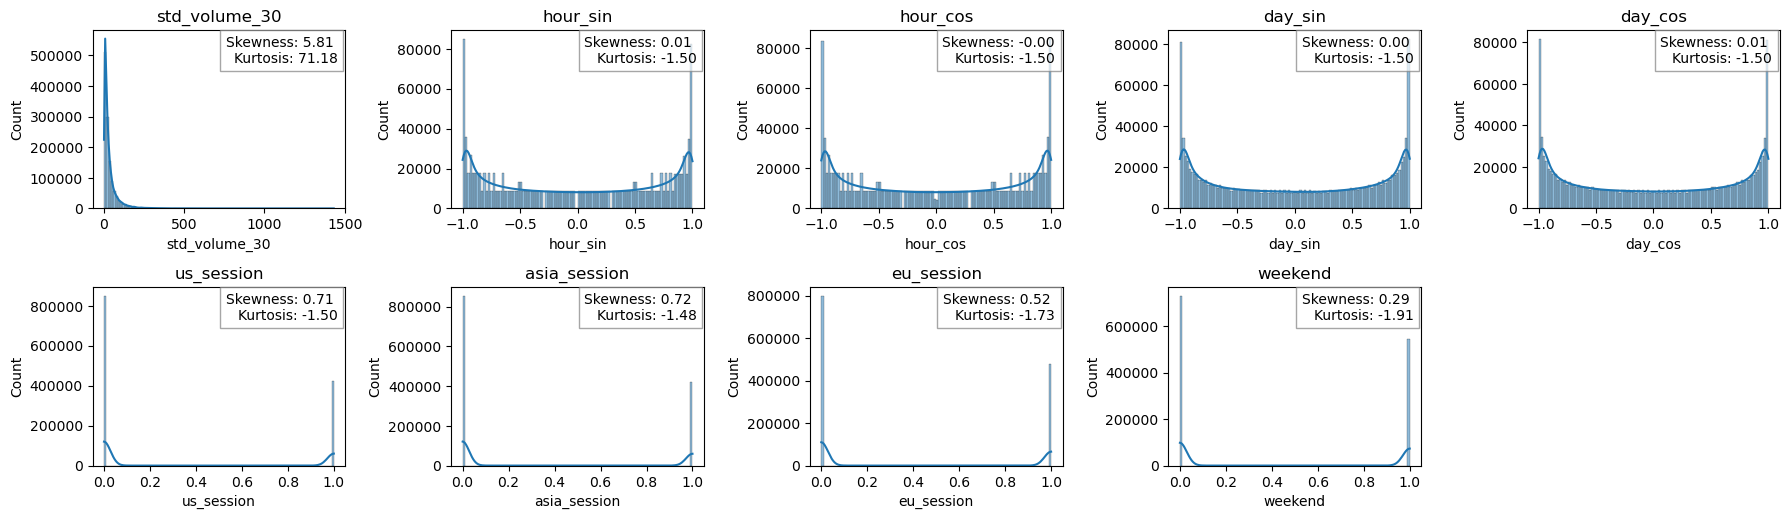

In [66]:
plot_distributions(features)

## **Data Pre-processing**

In [1591]:
class YeoJohnsonTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.transformer = PowerTransformer(method='yeo-johnson')
        self._transform_kind = None 

    def set_output(self, transform=None):
        self._transform_kind = transform
        return self

    def fit(self, X, y=None):
        self.transformer.fit(X)
        return self

    def transform(self, X):
        transformed = self.transformer.transform(X)
        if self._transform_kind == 'pandas':
            if hasattr(X, "columns"):
                return pd.DataFrame(transformed, columns=X.columns, index=X.index)
            else:
                return pd.DataFrame(transformed)
        else:
            return transformed
        
    def get_feature_names_out(self):
        pass
    

class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, limits=[0.01, 0.01]):
        self.limits = limits
        self._transform_kind = None

    def set_output(self, transform=None):
        self._transform_kind = transform
        return self

    def fit(self, X, y=None):
        # Winsorizer does not need to learn any parameters from X
        return self

    def transform(self, X):
        if hasattr(X, "columns"):
            X_values = X.values
            col_names = X.columns
            idx = X.index
        else:
            X_values = X
            col_names = None
            idx = None

        winsorized = np.apply_along_axis(
            lambda col: mstats.winsorize(col, limits=self.limits),
            axis=0,
            arr=X_values
        )

        if self._transform_kind == "pandas":
            if col_names is not None:
                return pd.DataFrame(winsorized, columns=col_names, index=idx)
            else:
                return pd.DataFrame(winsorized)
        else:
            return winsorized
        
    def get_feature_names_out(self):
        pass
        

class DataProcessor:
    def __init__(self, 
                 include_scaling=None,
                 skew_threshold=2, 
                 kurtosis_threshold=10, 
                 winsor_limits=[0.01, 0.01]):
        self.include_scaling = include_scaling or []
        self.skew_threshold = skew_threshold
        self.kurtosis_threshold = kurtosis_threshold
        self.winsor_limits = winsor_limits
        
        self.preprocessing_pipeline = None
        self.final_pipeline = None

    def _categorize_features(self, X):
        categories = {
            'yeo_johnson_only': [],
            'winsorizing_only': [],
            'yeo_johnson_winsorizing': [],
            'none': []
        }

        for col in X.columns:
            col_skewness = skew(X[col])
            col_kurtosis = kurtosis(X[col], fisher=False)

            if (col_skewness > self.skew_threshold) & (col_kurtosis > self.kurtosis_threshold):
                categories['yeo_johnson_winsorizing'].append(col)
            elif col_skewness > self.skew_threshold:
                categories['yeo_johnson_only'].append(col)
            elif col_kurtosis > self.kurtosis_threshold:
                categories['winsorizing_only'].append(col)
            else:
                categories['none'].append(col)
                
        return categories

    def _build_pipeline(self, columns, categories):
        preprocessing_pipeline = ColumnTransformer(
            transformers=[
                ('yeo_johnson_only', YeoJohnsonTransformer(), 
                categories['yeo_johnson_only']),
        
                ('winsorizing_only', Winsorizer(limits=self.winsor_limits),
                categories['winsorizing_only']),
                
                ('yeo_johnson_winsorizing', Pipeline([
                    ('yeo_johnson', YeoJohnsonTransformer()),
                    ('winsor', Winsorizer(limits=self.winsor_limits))
                ]), categories['yeo_johnson_winsorizing']),

                ('none', 'passthrough', categories['none'])
            ], 
            n_jobs=-1
        )
        
        include_scaling = [i for i, col in enumerate(columns) if col in self.include_scaling]
        
        scaling_transformer = ColumnTransformer(
            transformers=[
                ('scaler', StandardScaler(), include_scaling)
            ],
            remainder='passthrough', verbose_feature_names_out=False
        )
        
        final_pipeline = Pipeline([
            ('preprocessing', preprocessing_pipeline),
            ('scaling', scaling_transformer)
        ])

        return final_pipeline

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X).copy()
        columns = X_df.columns
        categories = self._categorize_features(X_df)
        self.final_pipeline = self._build_pipeline(columns, categories)
        self.final_pipeline.fit(X_df, y)
        return self

    def transform(self, X, y=None):
        X_df = pd.DataFrame(X).copy()
        return pd.DataFrame(self.final_pipeline.transform(X_df), index=X_df.index, columns=X_df.columns)

    def fit_transform(self, X, y=None):
        X_df = pd.DataFrame(X).copy()
        self.fit(X_df, y)
        return pd.DataFrame(self.final_pipeline.transform(X_df), index=X_df.index, columns=X_df.columns)

In [1564]:
features_pd = features.to_pandas().set_index("Date")
include_scaling = features_pd.loc[:, :"hour_sin"].columns.tolist()[:-1]
dp = DataProcessor(include_scaling=include_scaling)
features_cleaned = dp.fit(features_pd).transform(features_pd)
features_cleaned

AttributeError: 'Index' object has no attribute 'to_pandas'

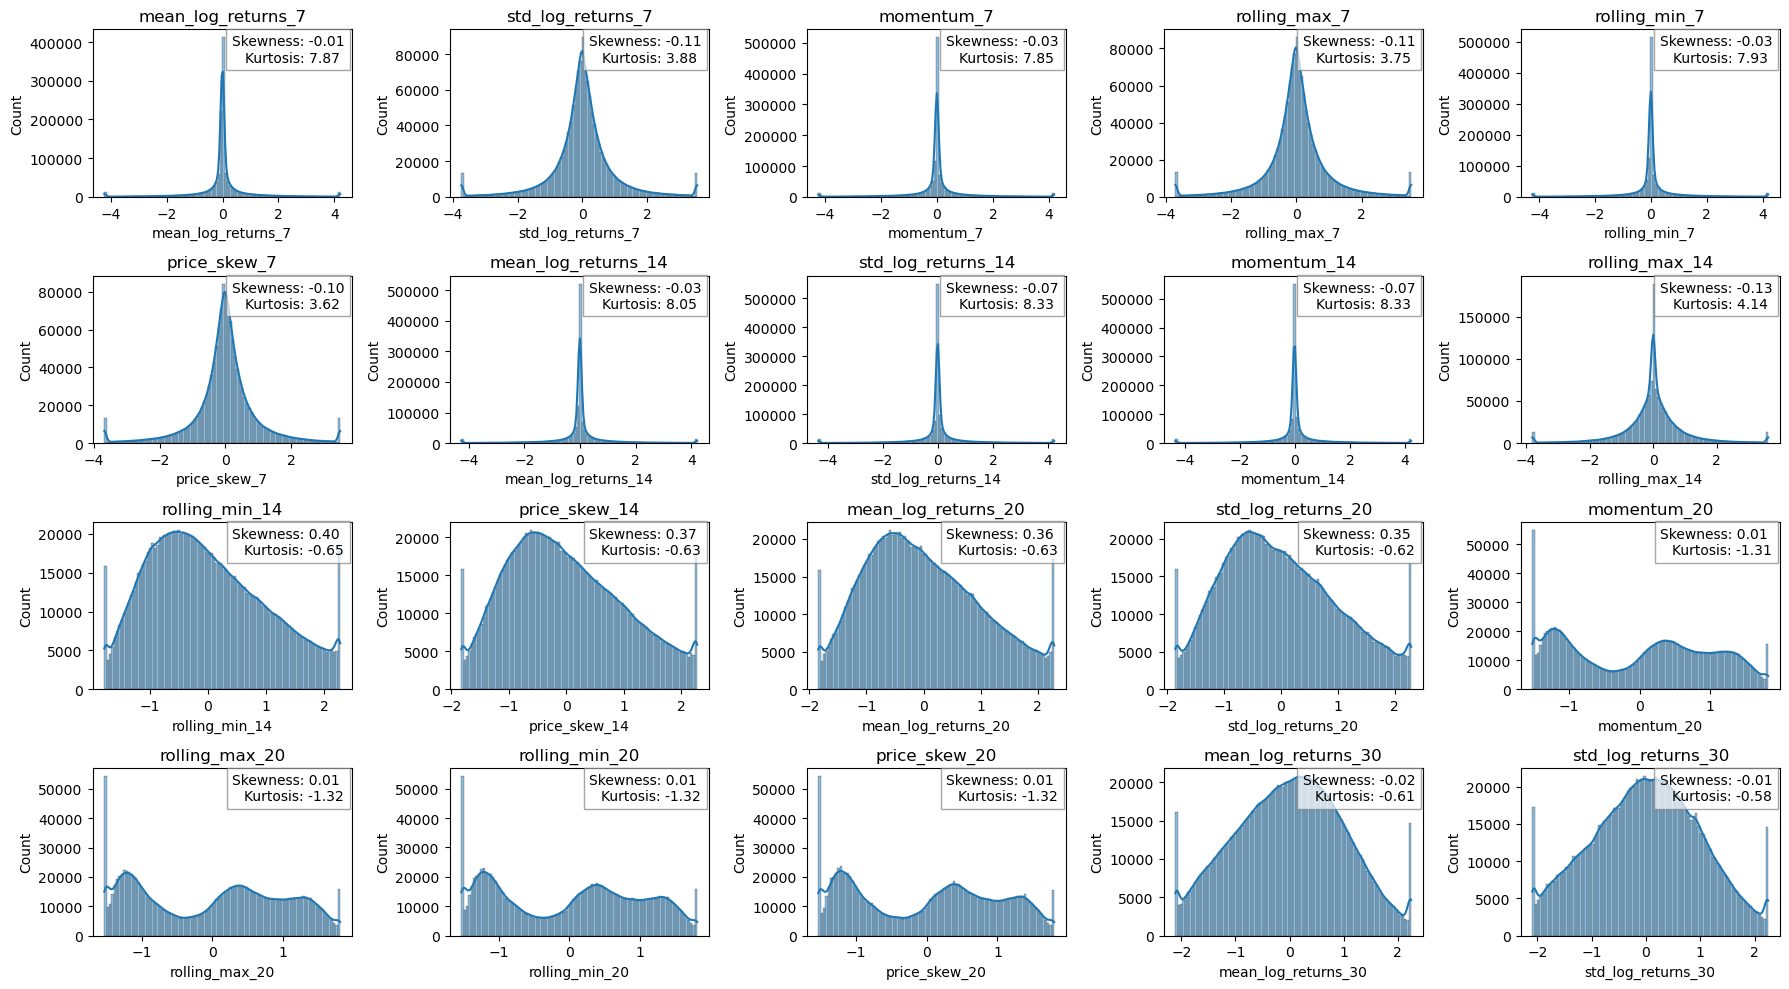

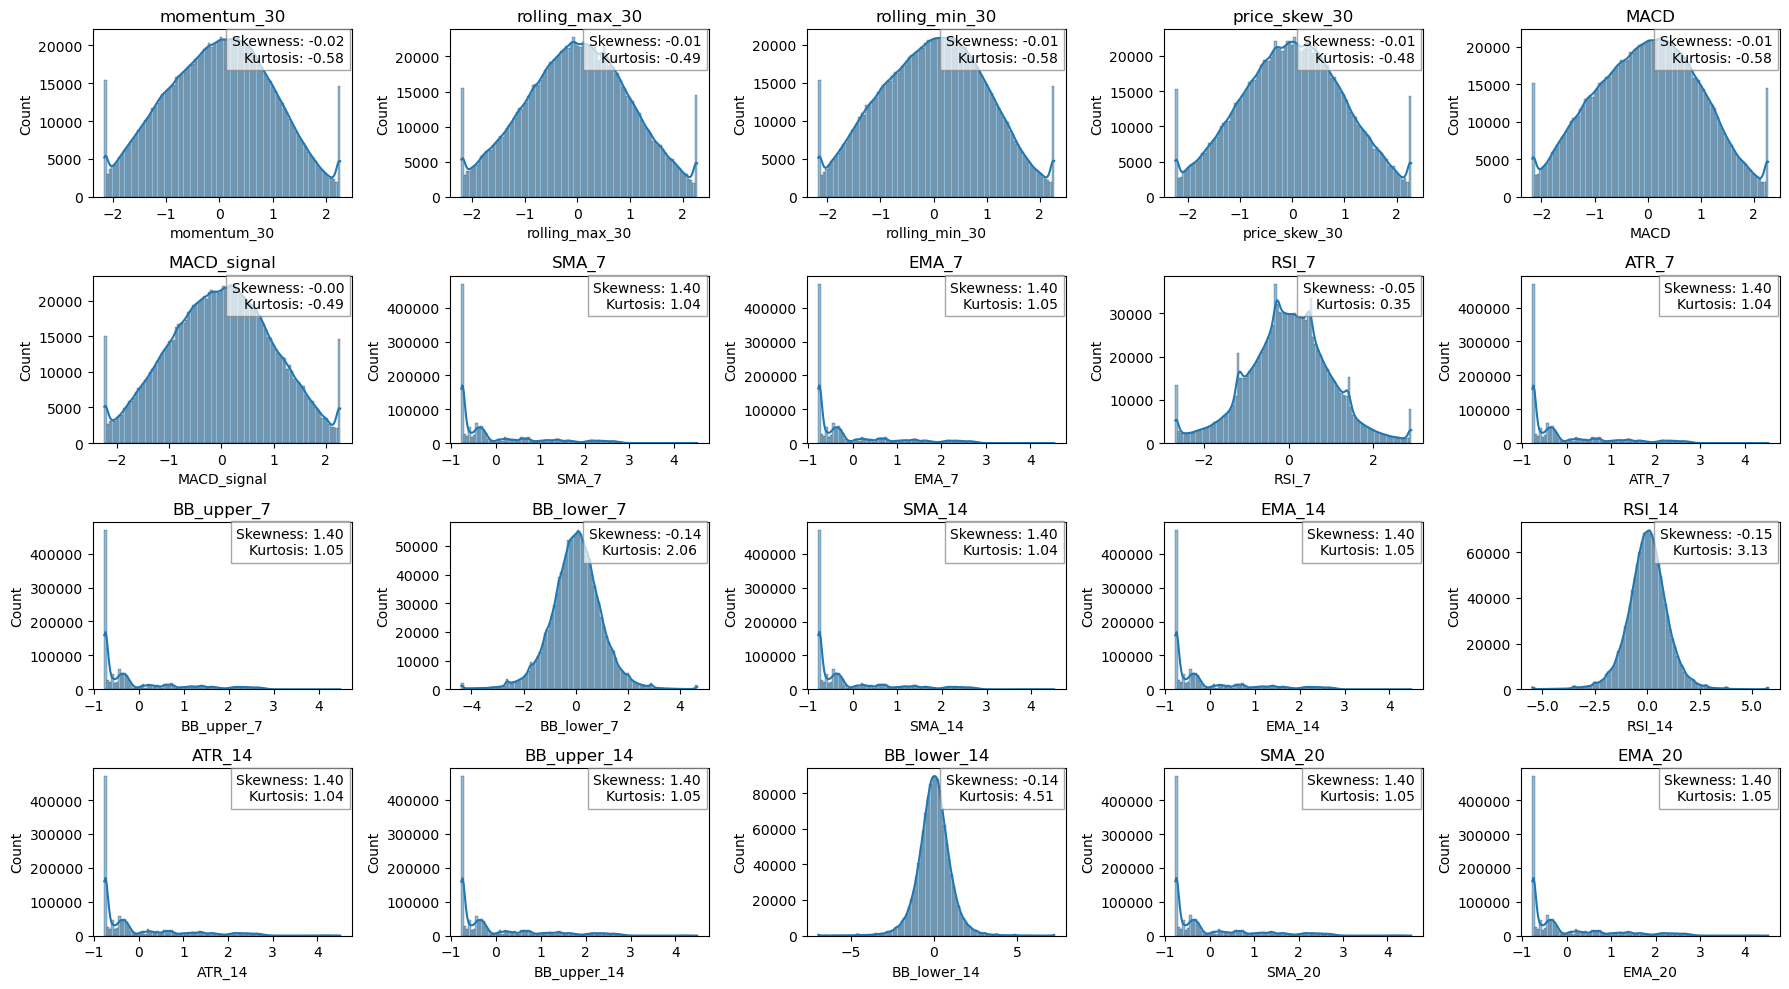

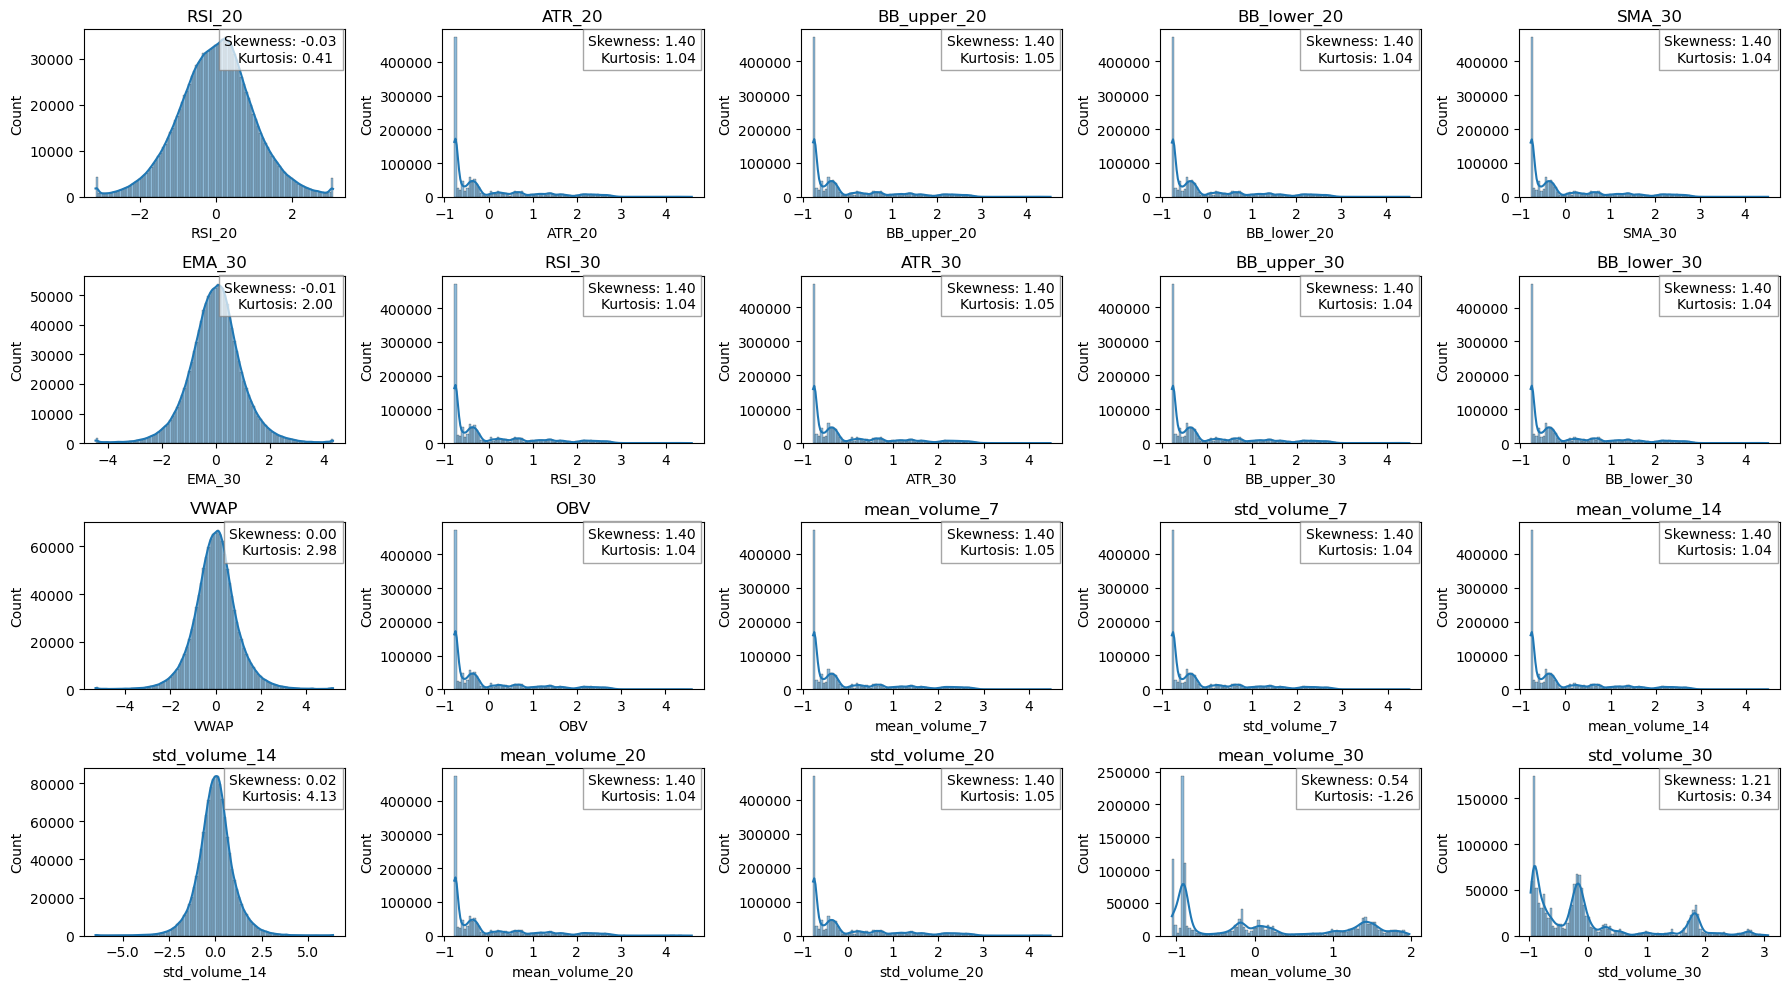

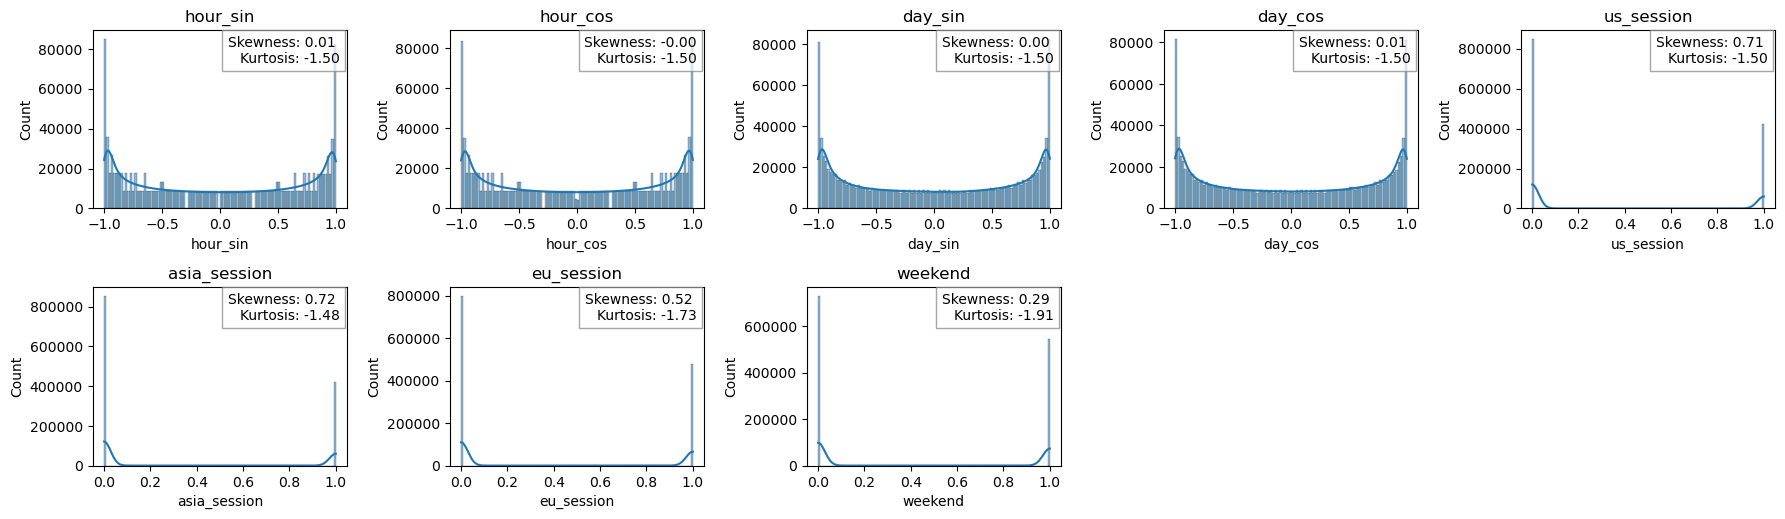

In [67]:
plot_distributions(features_cleaned)

## **Reducing the feature space: Encoder-Decoder**

In [708]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
        )
        
        self.criterion = None
        self.optimizer = None

    def forward(self, x):
        z = self.encoder(x)        # compress to latent
        x_recon = self.decoder(z)  # reconstruct
        return x_recon

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def fit(self, X, epochs=20, batch_size=128, lr=1e-3, device='cpu'):
        """
        Train the autoencoder on data X (numpy array or torch tensor).
        
        Args:
            X (np.ndarray or torch.Tensor): data of shape (n_samples, input_dim).
            epochs (int): number of training epochs.
            batch_size (int): mini-batch size.
            lr (float): learning rate.
            device (str): 'cpu' or 'cuda' for GPU.
        """
        self.to(device)

        X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32)
        
        # Create dataset & dataloader (AE target = input)
        dataset = TensorDataset(X_tensor, X_tensor)
        data_loader = DataLoader(dataset, batch_size=batch_size)
        
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        
        self.train()
        for epoch in range(epochs):
            total_loss = 0.0
            for batch_x, _ in data_loader:
                batch_x = batch_x.to(device)
                
                # Forward prop
                x_recon = self(batch_x)
                loss = self.criterion(x_recon, batch_x)
                
                # Backprop
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item() * batch_x.size(0)
            
            avg_loss = total_loss / len(dataset)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

        return self

    def transform(self, X, batch_size=128, device='cpu'):
        """
        Encode input data X into the latent space.

        Args:
            X (np.ndarray or torch.Tensor): shape (n_samples, input_dim).
            batch_size (int): batch size for inference.
            device (str): 'cpu' or 'cuda' for GPU.

        Returns:
            z_all (torch.Tensor): shape (n_samples, latent_dim).
        """
        self.to(device)

        X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32)        
        data_loader = DataLoader(TensorDataset(X_tensor), batch_size=batch_size)
        
        z_list = []
        self.eval()
        with torch.no_grad():
            for (batch_x,) in data_loader:
                batch_x = batch_x.to(device)
                z = self.encode(batch_x)
                z_list.append(z.cpu())
        
        z_all = torch.cat(z_list, dim=0)
        z_all = pd.DataFrame(
            z_all.numpy(), 
            index=X.index, 
            columns=[f"encoded_{i+1}" for i in range(z_all.shape[1])]
        )

        return z_all

In [ ]:
ae = Autoencoder(features_cleaned.shape[1])
ae.fit(features_cleaned)
features_red = ae.transform(features_cleaned)

Epoch [1/20], Loss: 0.0623
Epoch [2/20], Loss: 0.0500
Epoch [3/20], Loss: 0.0484
Epoch [4/20], Loss: 0.0477
Epoch [5/20], Loss: 0.0470
Epoch [6/20], Loss: 0.0459
Epoch [7/20], Loss: 0.0435
Epoch [8/20], Loss: 0.0412
Epoch [9/20], Loss: 0.0382
Epoch [10/20], Loss: 0.0358
Epoch [11/20], Loss: 0.0346
Epoch [12/20], Loss: 0.0339
Epoch [13/20], Loss: 0.0335
Epoch [14/20], Loss: 0.0333
Epoch [15/20], Loss: 0.0331
Epoch [16/20], Loss: 0.0330
Epoch [17/20], Loss: 0.0329
Epoch [18/20], Loss: 0.0327
Epoch [19/20], Loss: 0.0327
Epoch [20/20], Loss: 0.0326


<Axes: xlabel='Date'>

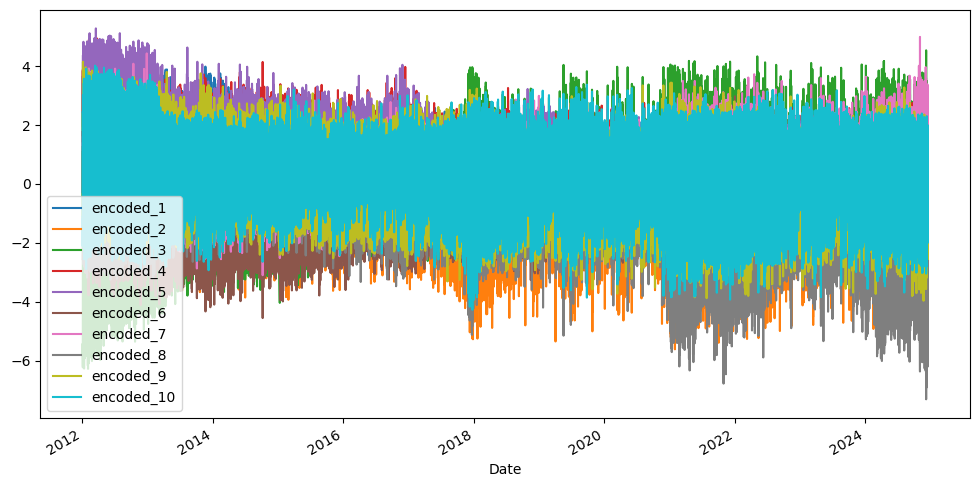

In [ ]:
features_red.plot(figsize=(12, 6))

## **Target Variable**

Because of the complexity of return predictions due to the low noise-to-signal ratio, we are goign to predict the direction of the momentum for the next periods. For that, we can derive many useful fetaures from the OHLCV data which with the obejcitve that they will have predictive power to predict the direction of the momentum.

In [ ]:
def create_target(prices, window=20):
    momentum = prices.with_columns(
        ((pl.col("Close") / pl.col("Close").shift(window)) - 1).shift(-window).alias("momentum")
    ).with_columns(
        pl.when(pl.col("momentum") > 0)
        .then(1)
        .otherwise(0)
        .cast(pl.Int8)
        .alias("target")
    ).select("Date", "target")

    return momentum

target = create_target(bitcoin, window=20)
target = target.to_pandas().set_index("Date")
target = target.loc[features_red.index]
target

target
Date                       
2012-01-02 03:45:00       0
2012-01-02 03:50:00       0
2012-01-02 03:55:00       0
2012-01-02 04:00:00       0
2012-01-02 04:05:00       0
...                     ...
2024-12-15 23:40:00       0
2024-12-15 23:45:00       0
2024-12-15 23:50:00       0
2024-12-15 23:55:00       0
2024-12-16 00:00:00       0

[1275470 rows x 1 columns]

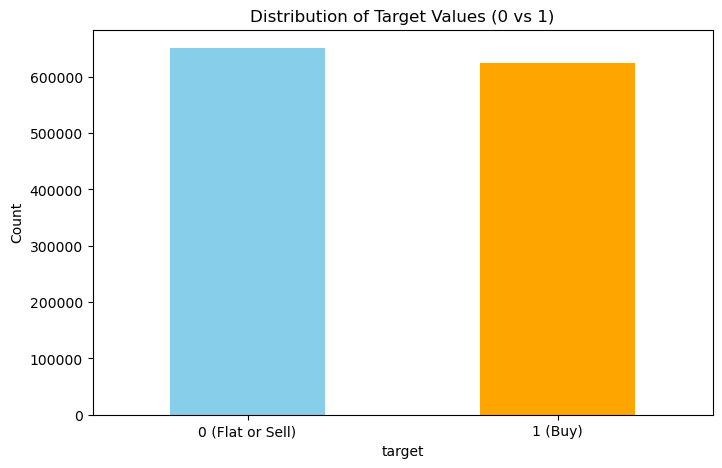

In [1321]:
target_counts = target.value_counts()

plt.figure(figsize=(8, 5))
target_counts.plot(kind="bar", color=['skyblue', 'orange'])
plt.xticks([0, 1], ['0 (Flat or Sell)', '1 (Buy)'], rotation=0)
plt.ylabel('Count')
plt.title('Distribution of Target Values (0 vs 1)')
plt.show()

### **Long Short Term Memory (LSTM)**

In [454]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, n_units=50, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, n_units, batch_first=True)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else None
        self.fc = nn.Linear(n_units, 1)

    def forward(self, x):
        out, _ = self.lstm(x)  # out: (batch, timesteps, n_units)
        out = out[:, -1, :]    # Take the last timestep's output
        if self.dropout:
            out = self.dropout(out)
        out = self.fc(out)     # (batch, 1)
        return out


class LSTMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self,
                 learning_rate=0.01,
                 n_units=50,
                 dropout=0.0,
                 loss='bce',        # 'bce' for binary classification
                 epochs=10,
                 batch_size=32,
                 verbose=0,
                 patience=3,
                 seq_len=10,
                 n_workers=0,
                 device=None):
        self.learning_rate = learning_rate
        self.n_units = n_units
        self.dropout = dropout
        self.loss = loss
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.patience = patience
        self.seq_len = seq_len
        self.n_workers = n_workers

        if device is None:
            if torch.backends.mps.is_available():
                self.device = torch.device("mps")
            elif torch.cuda.is_available():
                self.device = torch.device("cuda")
            else:
                self.device = torch.device("cpu")
        else:
            self.device = torch.device(device)

        self.model_ = None

    def _get_loss_function(self):
        if self.loss == 'bce':
            return nn.BCEWithLogitsLoss()
        else:
            raise ValueError(f"Unsupported loss for classification: {self.loss}")

    def _create_sequences(self, X, y=None):
        N, _ = X.shape
        if N <= self.seq_len:
            raise ValueError("Number of observations must be > seq_len.")

        X_seq = []
        if y is not None:
            y_seq = []

        for i in range(N - self.seq_len):
            X_seq.append(X[i:i+self.seq_len, :])
            if y is not None:
                y_seq.append(y[i + self.seq_len])

        X_seq = np.array(X_seq, dtype=np.float32)   # shape: (N - seq_len, seq_len, num_features)
        if y is not None:
            y_seq = np.array(y_seq, dtype=np.float32)
            return X_seq, y_seq
        return X_seq

    def build_model(self, input_size):
        model = LSTMModel(n_units=self.n_units, 
                                    input_size=input_size,
                                    dropout=self.dropout)
        return model.to(self.device)

    def fit(self, X_train, y_train):
        if isinstance(X_train, pd.DataFrame):
            X_train = X_train.to_numpy()
        if isinstance(y_train, (pd.Series, pd.DataFrame)):
            y_train = y_train.to_numpy().ravel()

        X_train_seq, y_train_seq = self._create_sequences(X_train, y_train)

        X_train_t = torch.tensor(X_train_seq, device=self.device)
        y_train_t = torch.tensor(y_train_seq, device=self.device).unsqueeze(-1)  # shape: (batch, 1)

        _, _, input_size = X_train_seq.shape
        if self.model_ is None:
            self.model_ = self.build_model(input_size)

        dataset = TensorDataset(X_train_t, y_train_t)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, num_workers=self.n_workers)

        optimizer = Adam(self.model_.parameters(), lr=self.learning_rate)
        criterion = self._get_loss_function()

        best_loss = np.inf
        epochs_no_improve = 0

        # Training loop
        for epoch in range(self.epochs):
            self.model_.train()
            epoch_loss = 0.0

            for X_batch, y_batch in dataloader:
                optimizer.zero_grad()
                logits = self.model_(X_batch)
                loss_val = criterion(logits, y_batch)
                loss_val.backward()
                optimizer.step()

                epoch_loss += loss_val.item() * X_batch.size(0)

            epoch_loss /= len(dataset)
            if self.verbose:
                print(f"Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss:.4f}")

            # Early stopping check
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= self.patience:
                    if self.verbose:
                        print("Early stopping triggered.")
                    break

        return self

    def predict(self, X_test):
        if isinstance(X_test, pd.DataFrame):
            X_test = X_test.values

        X_test_seq = self._create_sequences(X_test)  # no y

        self.model_.eval()
        with torch.no_grad():
            X_test_t = torch.tensor(X_test_seq, device=self.device)
            logits = self.model_(X_test_t)  # shape: (N, 1)
            # Convert logits -> probabilities -> 0/1
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()  # threshold at 0.5
            
            return preds.cpu().numpy().ravel().astype(int)

    def predict_proba(self, X_test):
        if isinstance(X_test, pd.DataFrame):
            X_test = X_test.to_numpy()

        X_test_seq = self._create_sequences(X_test)

        self.model_.eval()
        with torch.no_grad():
            X_test_t = torch.tensor(X_test_seq, device=self.device)
            logits = self.model_(X_test_t)
            probs = torch.sigmoid(logits).squeeze()
            return probs.cpu().numpy()

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        self.model_ = None # rebuild the model
        return self

    def get_params(self, deep=True):
        return {
            'learning_rate': self.learning_rate,
            'n_units': self.n_units,
            'dropout': self.dropout,
            'loss': self.loss,
            'epochs': self.epochs,
            'batch_size': self.batch_size,
            'verbose': self.verbose,
            'patience': self.patience,
            'seq_len': self.seq_len,
            'device': self.device.type if isinstance(self.device, torch.device) else self.device
        }

In [462]:
scaling_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), include_scaling)
    ],
    remainder='passthrough', verbose_feature_names_out=False
)
features_cleaned = scaling_transformer.fit_transform(features_pd)
np.mean(features_cleaned, axis=0)

In [471]:
features_red = pd.DataFrame(
    features_red.numpy(), 
    index=features_pd.index, 
    columns=[f"encoded_{i+1}" for i in range(features_red.shape[1])]
)
features_red

AttributeError: 'DataFrame' object has no attribute 'numpy'

In [ ]:
ae = Autoencoder(features_cleaned.shape[1])
ae.fit(features_cleaned)
features_red = ae.transform(features_cleaned)

features_red = pd.DataFrame(
    features_red.numpy(), 
    index=features.index, 
    columns=[f"encoded_{i+1}" for i in range(features_red.shape[1])]
)

Epoch [1/20], Loss: 0.0653
Epoch [2/20], Loss: 0.0449
Epoch [3/20], Loss: 0.0421
Epoch [4/20], Loss: 0.0405
Epoch [5/20], Loss: 0.0392
Epoch [6/20], Loss: 0.0387
Epoch [7/20], Loss: 0.0379
Epoch [8/20], Loss: 0.0373
Epoch [9/20], Loss: 0.0360
Epoch [10/20], Loss: 0.0349
Epoch [11/20], Loss: 0.0341
Epoch [12/20], Loss: 0.0335
Epoch [13/20], Loss: 0.0330
Epoch [14/20], Loss: 0.0327
Epoch [15/20], Loss: 0.0325
Epoch [16/20], Loss: 0.0322
Epoch [17/20], Loss: 0.0321
Epoch [18/20], Loss: 0.0320
Epoch [19/20], Loss: 0.0318
Epoch [20/20], Loss: 0.0319


AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [1517]:
import xgboost as xgb

xgb_cl = xgb.XGBClassifier(max_depth=4, n_estimators=500, n_jobs=-1, learning_rate=0.1)
xgb_cl.fit(features_a.loc["2012":"2022-03-15"].to_numpy(), target.loc["2012":"2022-03-15"].to_numpy().ravel())

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [1518]:
#y_pred = xgb_cl.predict(features_a.loc["2022-03-01":"2022-03-30"])
y_pred = xgb_cl.predict_proba(features_a.loc["2022-03-16":"2022-03-30"].to_numpy())[:, 1]

In [1444]:
import lightgbm as lgb
lgb_cl = lgb.LGBMClassifier(max_depth=6, n_estimators=500, learning_rate=0.1)
lgb_cl.fit(features_a.loc["2012":"2022-02"].to_numpy(), target.loc["2012":"2022-02"].to_numpy().ravel())

[LightGBM] [Info] Number of positive: 510799, number of negative: 487672
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 998471, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511581 -> initscore=0.046333
[LightGBM] [Info] Start training from score 0.046333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(max_depth=6, n_estimators=500)

In [1481]:
y_pred = lgb_cl.predict(features_a.loc["2022-03-01":"2022-03-30"])
y_pred = lgb_cl.predict_proba(features_a.loc["2022-03-01":"2022-03-30"])[:, 1]

In [1522]:
from sklearn.ensemble import RandomForestClassifier

rf_cl = RandomForestClassifier(n_estimators=500, n_jobs=-1, max_depth=10)
rf_cl.fit(features_a.loc["2012":"2022-03-15"].to_numpy(), target.loc["2012":"2022-03-15"].to_numpy().ravel())

RandomForestClassifier(max_depth=10, n_estimators=500, n_jobs=-1)

In [1526]:
y_pred = rf_cl.predict(features_a.loc["2021-03-01"])
y_pred = rf_cl.predict_proba(features_a.loc["2022-03-16":"2022-03-30"])[:, 1]

/Users/anthony/miniforge3/envs/momentum_trading/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/anthony/miniforge3/envs/momentum_trading/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


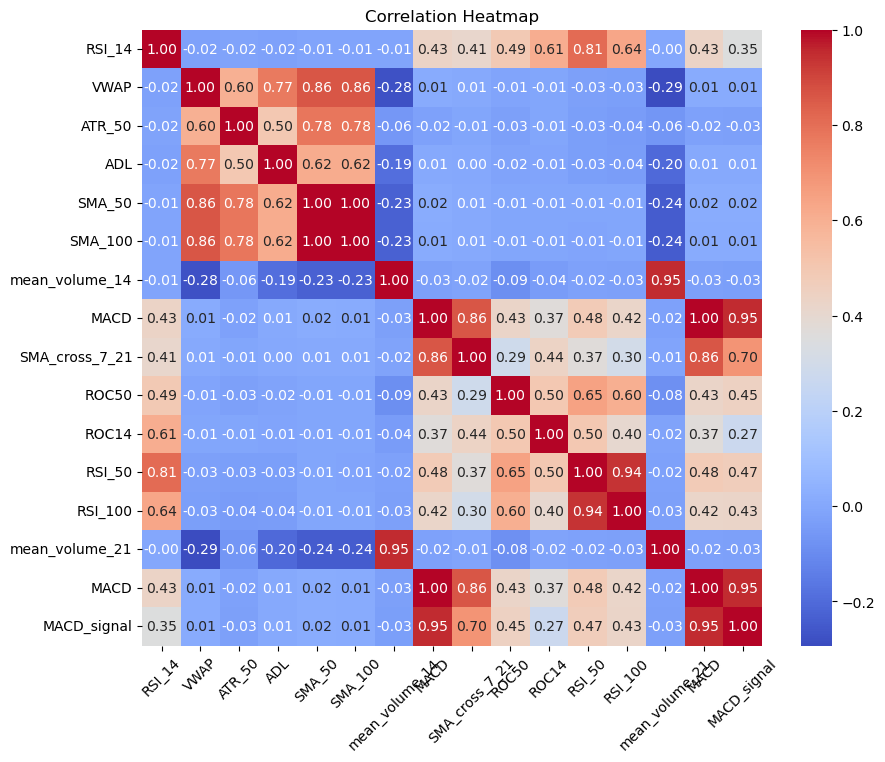

In [1440]:
plt.figure(figsize=(10, 8))
sns.heatmap(features_a.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.yticks(rotation=0)  # Keep y-axis labels horizontal for clarity
plt.show()

In [1401]:
features_a = features_a.loc[:, ~features_a.columns.str.contains("session")]

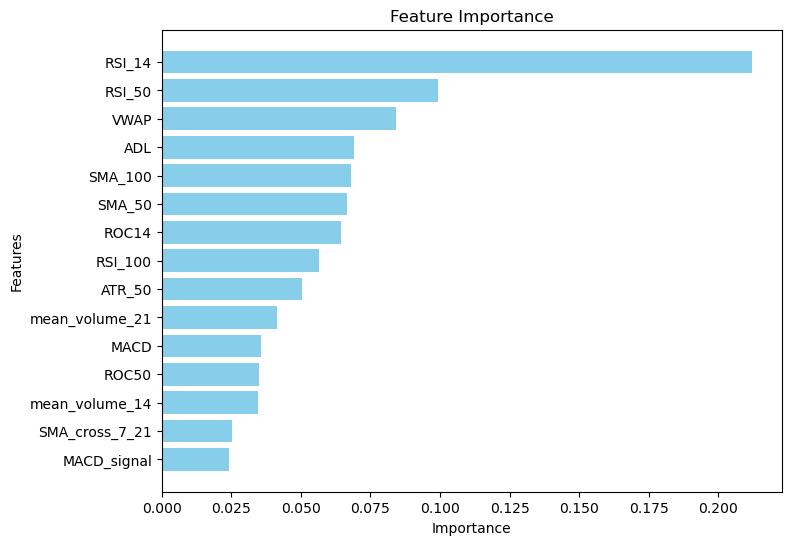

In [1524]:
feature_importances = rf_cl.feature_importances_
features = features_a.columns

importance = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance = importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(importance['Feature'], importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis() 
plt.show()

In [455]:
lstm = LSTMClassifier(verbose=1, epochs=8, dropout=0.1, n_units=100)
lstm.fit(features_red.loc["2012":"2021"], target.loc["2012":"2021"])

Epoch 1/8, Loss: 0.6897
Epoch 2/8, Loss: 0.6886
Epoch 3/8, Loss: 0.6890
Epoch 4/8, Loss: 0.6888
Epoch 5/8, Loss: 0.6886
Epoch 6/8, Loss: 0.6886
Epoch 7/8, Loss: 0.6888
Epoch 8/8, Loss: 0.6887
Early stopping triggered.


LSTMClassifier(device='mps', dropout=0.1, epochs=8, n_units=100, verbose=1)

In [ ]:
y_pred = lstm.predict(features_red.loc["2016"])
y_pred = lstm.predict_proba(features_red.loc["2021"])

In [642]:
def plot_roc_curve(y_true, y_pred):
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)

    # Compute AUC
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line (random classifier)
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [1247]:
y_pred

array([0, 0, 0, ..., 1, 1, 1], shape=(2880,), dtype=int8)

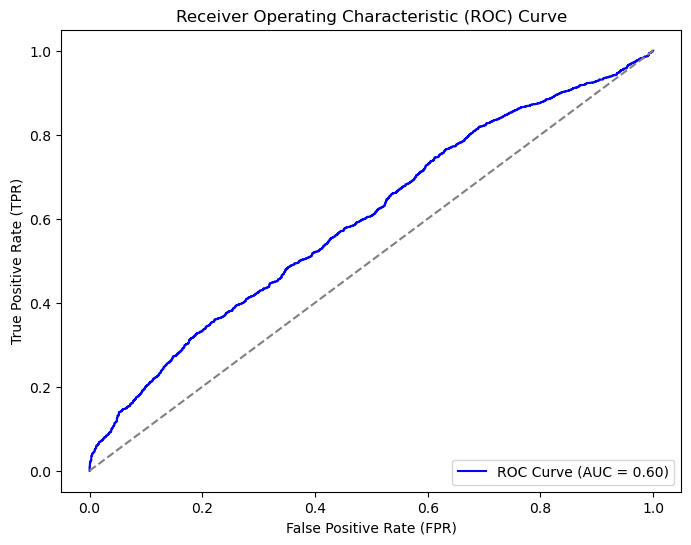

In [1527]:
plot_roc_curve(target.loc["2022-03-16":"2022-03-30"], y_pred)
#plot_roc_curve(backtester.y_test, backtester.y_pred)

In [1295]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(accuracy_score(target.loc["2022-03-01":"2022-03-30"], y_pred))

confusion_matrix(target.loc["2022-03-01":"2022-03-30"], y_pred)

0.5590277777777778


array([[689, 667],
       [603, 921]])

In [1502]:
f = features_pd.loc["2022-03-16":"2022-03-30"]

In [1413]:
ret = bitcoin.to_pandas().set_index("Date")["Close"].pct_change()
close = bitcoin.to_pandas().set_index("Date")["Close"]

In [1561]:
results = pd.DataFrame(index=f.index)
results["prediction"] = y_pred
results["position"] = 0
results["pnl"] = 0.0
results["take_profit"] = np.nan
results["stop_loss"]  = np.nan
results["holding_time"] = 0

max_holding_period = 12
curr_pos = 0
tp_value = np.nan
sl_value = np.nan
hold_time = 0

for i in range(len(results)):
    # If no position, check entry
    if curr_pos == 0:
        if results.at[results.index[i], "prediction"] > 0.7:
            tp_value = close.loc[results.index[i]] * (1 + 0.2)
            sl_value = close.loc[results.index[i]] * (1 - 0.2)
            curr_pos = 1
            hold_time = 0
            
        elif results.at[results.index[i], "prediction"] < 0.3:
            tp_value = close.loc[results.index[i]] * (1 - 0.2)
            sl_value = close.loc[results.index[i]] * (1 + 0.2)
            curr_pos = -1
            hold_time = 0

    else:  # Already in a position, check exit
        if curr_pos == 1:
            if (close.loc[results.index[i]] >= tp_value) or (close.loc[results.index[i]] <= sl_value):
                curr_pos = 0
            elif hold_time >= max_holding_period:
                curr_pos = 0
            else:
                hold_time += 1

        elif curr_pos == -1:
            if (close.loc[results.index[i]] <= tp_value) or (close.loc[results.index[i]] >= sl_value):
                curr_pos = 0
            elif hold_time >= max_holding_period:
                curr_pos = 0
            else:
                hold_time += 1

    results.at[results.index[i], "position"] = curr_pos
    results.at[results.index[i], "take_profit"] = tp_value
    results.at[results.index[i], "stop_loss"]  = sl_value
    results.at[results.index[i], "holding_time"] = hold_time

    # PnL calculation
    if i > 0:
        results.at[results.index[i], "pnl"] = (
            results.at[results.index[i-1], "position"] * ret.loc[results.index[i]]
        )
        # Transaction costs
        if results.at[results.index[i], "position"] != results.at[results.index[i-1], "position"]:
            results.at[results.index[i], "pnl"] -= 0.0008

results["cum_pnl"] = results["pnl"].cumsum()

<Axes: xlabel='Date'>

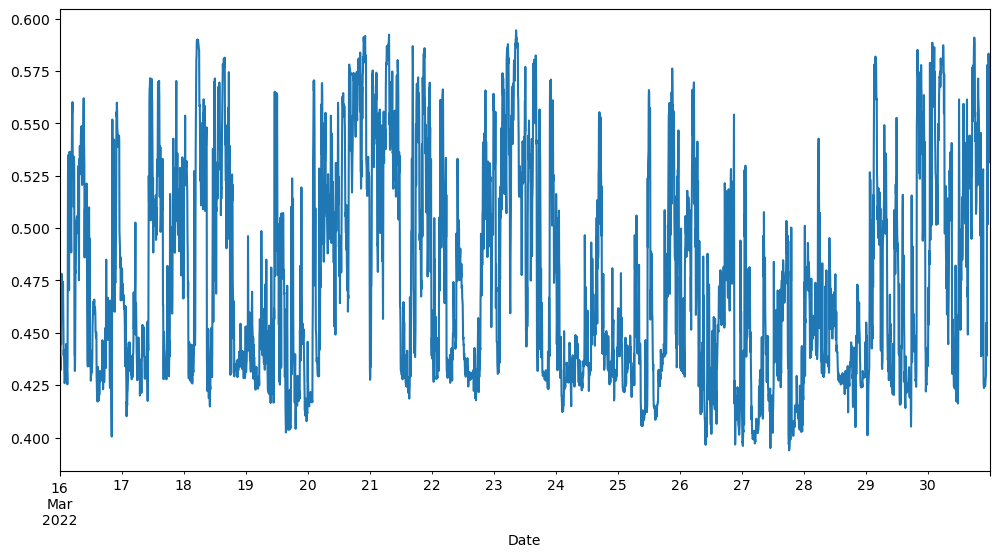

In [1529]:
results.loc["2022-03-09":, "prediction"].plot(figsize=(12, 6))

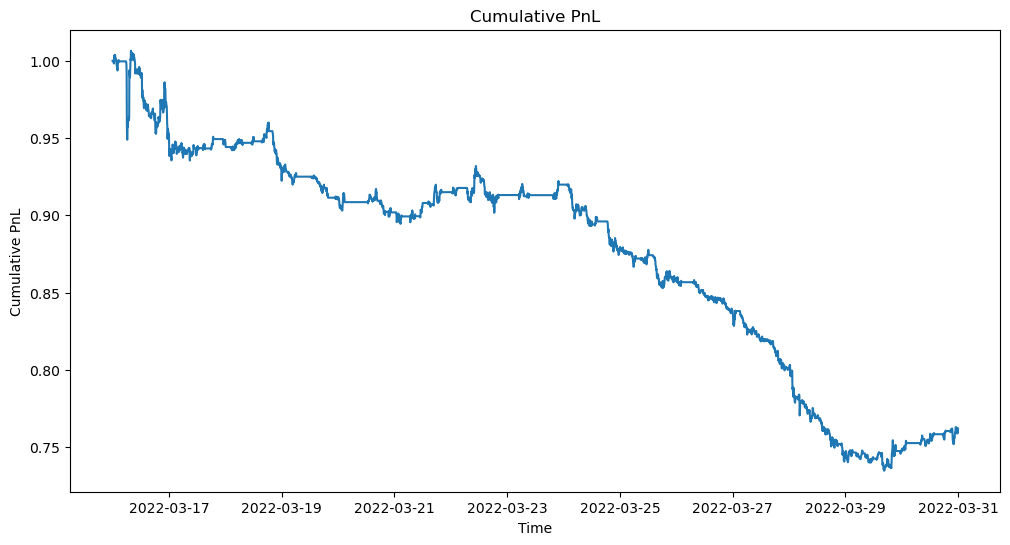

In [1504]:
# Cumulative PnL
results["cumulative_pnl"] = 1+results["pnl"].cumsum()

# Plot the cumulative PnL
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(results["cumulative_pnl"])
plt.title("Cumulative PnL")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.show()

In [1531]:
features_a = features_pd[["RSI_14", "VWAP", "ATR_50",
                        "ADL", "SMA_50", "SMA_100", "MACD", "ROC50", "ROC14",
                        "RSI_50", "RSI_100", "mean_volume_21", "MACD"]]
features_a

RSI_14         VWAP      ATR_50           ADL  \
Date                                                                     
2012-01-02 03:45:00  100.000000     4.920398    0.004079  1.000000e+01   
2012-01-02 03:50:00  100.000000     4.920398    0.003997  1.000000e+01   
2012-01-02 03:55:00  100.000000     4.920398    0.003917  1.000000e+01   
2012-01-02 04:00:00  100.000000     4.920398    0.003839  1.000000e+01   
2012-01-02 04:05:00  100.000000     4.920398    0.003762  1.000000e+01   
...                         ...          ...         ...           ...   
2024-12-15 23:40:00   74.459069  7551.462604  170.443701  2.035544e+06   
2024-12-15 23:45:00   75.198059  7551.476386  173.394827  2.035545e+06   
2024-12-15 23:50:00   67.582066  7551.487684  176.826930  2.035540e+06   
2024-12-15 23:55:00   64.255527  7551.572374  181.210392  2.035542e+06   
2024-12-16 00:00:00   66.154158  7551.579514  182.326184  2.035541e+06   

                          SMA_50      SMA_100        MACD     ROC50     ROC14  \
Date                                                                            
2012-01-02 03:45:00       4.8432       4.8130    0.013039  0.033058  0.033058   
2012-01-02 03:50:00       4.8464       4.8172    0.022873  0.033058  0.033058   
2012-01-02 03:55:00       4.8496       4.8214    0.030317  0.033058  0.033058   
2012-01-02 04:00:00       4.8528       4.8256    0.035804  0.033058  0.033058   
2012-01-02 04:05:00       4.8560       4.8298    0.039695  0.033058  0.033058   
...                          ...          ...         ...       ...       ...   
2024-12-15 23:40:00  103296.3400  103187.9300  435.296135  0.013878  0.013437   
2024-12-15 23:45:00  103327.4000  103206.7000  450.225722  0.015049  0.014813   
2024-12-15 23:50:00  103354.0000  103222.8900  439.481373  0.012888  0.012858   
2024-12-15 23:55:00  103379.1400  103238.6000  417.838577  0.012184  0.011341   
2024-12-16 00:00:00  103405.0600  103256.0500  404.815434  0.012553  0.012289   

                         RSI_50     RSI_100  mean_volume_21        MACD  
Date                                                                     
2012-01-02 03:45:00  100.000000  100.000000        0.480952    0.013039  
2012-01-02 03:50:00  100.000000  100.000000        0.480952    0.022873  
2012-01-02 03:55:00  100.000000  100.000000        0.480952    0.030317  
2012-01-02 04:00:00  100.000000  100.000000        0.480952    0.035804  
2012-01-02 04:05:00  100.000000  100.000000        0.480952    0.039695  
...                         ...         ...             ...         ...  
2024-12-15 23:40:00   64.514542   60.259048       15.520614  435.296135  
2024-12-15 23:45:00   64.924236   60.511121       14.866438  450.225722  
2024-12-15 23:50:00   62.270992   59.140718       14.988372  439.481373  
2024-12-15 23:55:00   61.062357   58.505457       16.484149  417.838577  
2024-12-16 00:00:00   61.861702   58.976491       15.644062  404.815434  

[1275470 rows x 13 columns]

In [1224]:
features_pd.columns

Index(['mean_log_returns_7', 'std_log_returns_7', 'momentum_7',
       'rolling_max_7', 'rolling_min_7', 'price_skew_7', 'mean_log_returns_14',
       'std_log_returns_14', 'momentum_14', 'rolling_max_14', 'rolling_min_14',
       'price_skew_14', 'mean_log_returns_21', 'std_log_returns_21',
       'momentum_21', 'rolling_max_21', 'rolling_min_21', 'price_skew_21',
       'mean_log_returns_50', 'std_log_returns_50', 'momentum_50',
       'rolling_max_50', 'rolling_min_50', 'price_skew_50',
       'mean_log_returns_100', 'std_log_returns_100', 'momentum_100',
       'rolling_max_100', 'rolling_min_100', 'price_skew_100', 'MACD',
       'MACD_signal', 'SMA_7', 'EMA_7', 'RSI_7', 'ADX_7', 'ATR_7', 'ROC7',
       'BB_upper_7', 'BB_lower_7', 'SMA_14', 'EMA_14', 'RSI_14', 'ADX_14',
       'ATR_14', 'ROC14', 'BB_upper_14', 'BB_lower_14', 'SMA_21', 'EMA_21',
       'RSI_21', 'ADX_21', 'ATR_21', 'ROC21', 'BB_upper_21', 'BB_lower_21',
       'SMA_50', 'EMA_50', 'RSI_50', 'ADX_50', 'ATR_50', 'ROC5

In [859]:
features_pd = features.to_pandas().set_index("Date")

np.int64(842)

In [1592]:
a = Autoencoder(input_dim=features_pd.shape[1])
d = DataProcessor(include_scaling=features_pd.columns.tolist())

In [1595]:
from backtesting import Backtester

In [1593]:
lstm = LSTMClassifier(n_units=100, epochs=5, seq_len=15)

In [1596]:
params = {
    "dropout": [0.2, 0.3]
}
backtester = Backtester(features_pd, target, close, lstm, params, data_processor=d, autoencoder=a)
backtester.run_backtest("2022", "2022-02")

Epoch [1/20], Loss: 0.1510
Epoch [2/20], Loss: 0.1126
Epoch [3/20], Loss: 0.1124
Epoch [4/20], Loss: 0.1144
Epoch [5/20], Loss: 0.1159
Epoch [6/20], Loss: 0.1085
Epoch [7/20], Loss: 0.1176
Epoch [8/20], Loss: 0.1218
Epoch [9/20], Loss: 0.1146
Epoch [10/20], Loss: 0.1169
Epoch [11/20], Loss: 0.1136
Epoch [12/20], Loss: 0.1102
Epoch [13/20], Loss: 0.1102
Epoch [14/20], Loss: 0.1075
Epoch [15/20], Loss: 0.1062
Epoch [16/20], Loss: 0.1073
Epoch [17/20], Loss: 0.1059
Epoch [18/20], Loss: 0.1043
Epoch [19/20], Loss: 0.1051
Epoch [20/20], Loss: 0.1056


NameError: name 'np' is not defined

In [1576]:
features_a

RSI_14         VWAP      ATR_50           ADL  \
Date                                                                     
2012-01-02 03:45:00  100.000000     4.920398    0.004079  1.000000e+01   
2012-01-02 03:50:00  100.000000     4.920398    0.003997  1.000000e+01   
2012-01-02 03:55:00  100.000000     4.920398    0.003917  1.000000e+01   
2012-01-02 04:00:00  100.000000     4.920398    0.003839  1.000000e+01   
2012-01-02 04:05:00  100.000000     4.920398    0.003762  1.000000e+01   
...                         ...          ...         ...           ...   
2024-12-15 23:40:00   74.459069  7551.462604  170.443701  2.035544e+06   
2024-12-15 23:45:00   75.198059  7551.476386  173.394827  2.035545e+06   
2024-12-15 23:50:00   67.582066  7551.487684  176.826930  2.035540e+06   
2024-12-15 23:55:00   64.255527  7551.572374  181.210392  2.035542e+06   
2024-12-16 00:00:00   66.154158  7551.579514  182.326184  2.035541e+06   

                          SMA_50      SMA_100        MACD     ROC50     ROC14  \
Date                                                                            
2012-01-02 03:45:00       4.8432       4.8130    0.013039  0.033058  0.033058   
2012-01-02 03:50:00       4.8464       4.8172    0.022873  0.033058  0.033058   
2012-01-02 03:55:00       4.8496       4.8214    0.030317  0.033058  0.033058   
2012-01-02 04:00:00       4.8528       4.8256    0.035804  0.033058  0.033058   
2012-01-02 04:05:00       4.8560       4.8298    0.039695  0.033058  0.033058   
...                          ...          ...         ...       ...       ...   
2024-12-15 23:40:00  103296.3400  103187.9300  435.296135  0.013878  0.013437   
2024-12-15 23:45:00  103327.4000  103206.7000  450.225722  0.015049  0.014813   
2024-12-15 23:50:00  103354.0000  103222.8900  439.481373  0.012888  0.012858   
2024-12-15 23:55:00  103379.1400  103238.6000  417.838577  0.012184  0.011341   
2024-12-16 00:00:00  103405.0600  103256.0500  404.815434  0.012553  0.012289   

                         RSI_50     RSI_100  mean_volume_21        MACD  
Date                                                                     
2012-01-02 03:45:00  100.000000  100.000000        0.480952    0.013039  
2012-01-02 03:50:00  100.000000  100.000000        0.480952    0.022873  
2012-01-02 03:55:00  100.000000  100.000000        0.480952    0.030317  
2012-01-02 04:00:00  100.000000  100.000000        0.480952    0.035804  
2012-01-02 04:05:00  100.000000  100.000000        0.480952    0.039695  
...                         ...         ...             ...         ...  
2024-12-15 23:40:00   64.514542   60.259048       15.520614  435.296135  
2024-12-15 23:45:00   64.924236   60.511121       14.866438  450.225722  
2024-12-15 23:50:00   62.270992   59.140718       14.988372  439.481373  
2024-12-15 23:55:00   61.062357   58.505457       16.484149  417.838577  
2024-12-16 00:00:00   61.861702   58.976491       15.644062  404.815434  

[1275470 rows x 13 columns]

In [ ]:
params = {
    "n_estimators": [200, 300, 500, 800],
    "learning_rate": [0.1, 0.05, 0.075],
    "max_depth": [5, 6, 7]
}
backtester = Backtester(features_a, target, close, xgb_cl, params, autoencoder=ae)
backtester.run_backtest("2022", "2022-06")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x13 and 68x64)

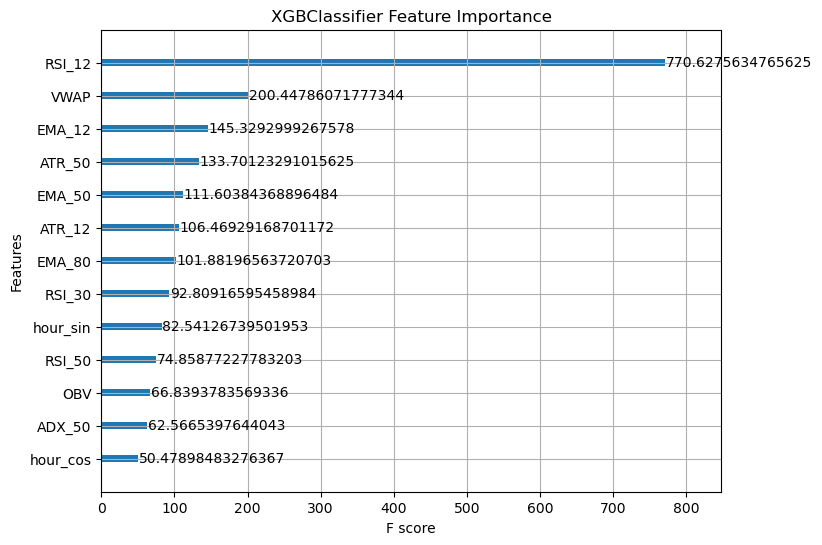

In [ ]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(8, 6))
plot_importance(xgb_cl, ax=ax, importance_type='gain', max_num_features=10)  
plt.title("XGBClassifier Feature Importance")
plt.show()

In [ ]:
from backtesting import Backtester

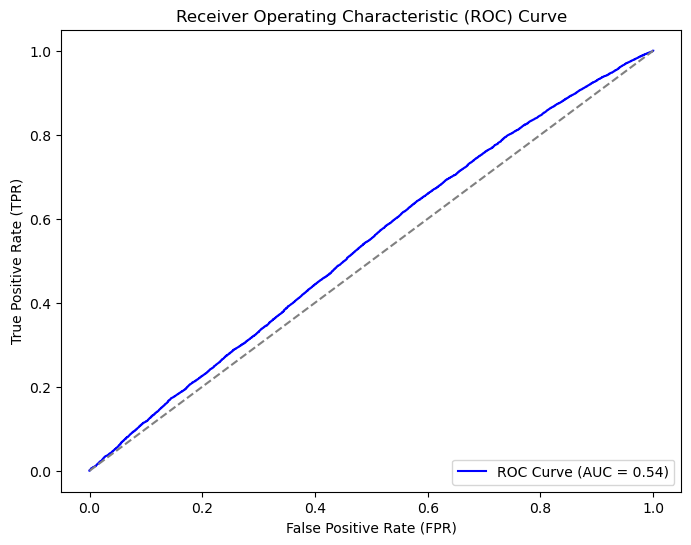

In [1556]:
plot_roc_curve(backtester.y_test, backtester.y_pred)

<Axes: xlabel='Date'>

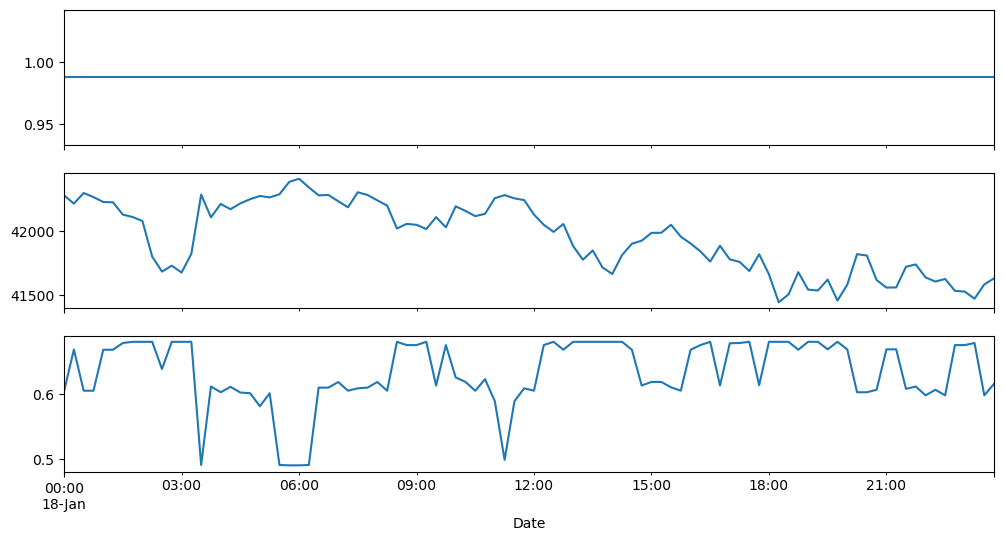

In [1026]:
date = "2022-01-18"
fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
backtester.results.loc[date,"cum_gross_pnl"].plot(ax=axes[0])
close.loc[date].plot(ax=axes[1])
backtester.results.loc[date,"prediction"].plot(ax=axes[2])